# Automobile Customer Segmentation: Unsupervised Machine Learning Investigation
Dataset
- Sales team at an automobile company has classified all customers into 4 segments (A, B, C, D ). A strategy of performing segmented outreach and communication has worked exceptionally well for them. 

Objective
- Can an unsupervised machine learning (ML) model predict the 4 segments?
    - or
- Is domain knowledge and further data required?

Approach
- Took training dataset and removed A-D segmentation to review against unsupervised ML results

Modelling approach
- Data preparation
    - Regularisation
        - Scaled by Z scale, Robust scale and Min max scale
        - Normalised by L1, L2 or Max normalisation
- PCA of original, scaled and normalised
- Unsupervised modelling
    - Forcing to 4 categories (k = 4) to match target set even if not optimal
    - K means (Km) clustering
        - Default settings, random state set to limit variation from setting initial centroids
        - K assessment using elbow method and silhouette score
     - Agglomerative (Aggl)/Hierarchical clustering
        - metric= "Euclidean", linkage = "ward”
        - Deterministic, random state not required
        - K assessment using silhouette score

LINKED NOTEBOOK*
- Notebook looking at affect of less features on models - Copied notebook, remodelled data for less factors and re-ran subsequent code (Customer Segmentation_ unsupervised learning_DBoland Feb 25 - less features.ipynb)

Future work/improvements
- Iterative approach taken – function or pipeline would reduce coding lines for review

Reference – Kaggle: Customer Segmentation Vetrivel-PS https://www.kaggle.com/datasets/vetrirah/customer/data License
CC0: Public Domain


# 1. Import Libraries

In [1193]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer,  MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 2. Exploratory data analysis
# 2.1  Initial exploration

In [1194]:
# load data
training_data = pd.read_csv("Train.csv")
# view data
training_data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [1195]:
# information on dataset
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Only ID, gender, age, spending_score and segmentation have full data

In [1196]:
# check for duplicate rows
duplic_check = training_data.drop_duplicates()
duplic_check.info()
# same row number as main data set - no duplicates 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [1197]:
# describe dataset statistics
training_data.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [1198]:
# value counts if datatype is a string
for i in training_data:
    data_type = training_data[i].dtype
    if data_type == "object":
        value_count = training_data[i].value_counts()
        print("\n",value_count)


 Gender
Male      4417
Female    3651
Name: count, dtype: int64

 Ever_Married
Yes    4643
No     3285
Name: count, dtype: int64

 Graduated
Yes    4968
No     3022
Name: count, dtype: int64

 Profession
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: count, dtype: int64

 Spending_Score
Low        4878
Average    1974
High       1216
Name: count, dtype: int64

 Var_1
Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: count, dtype: int64

 Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64


# 2.2 Handling null values and Data transformation of catergorical variables

Only ID, gender, age, spending_score and segmentation have full data

In [1199]:
# Create a table of null data to review 


# Filter rows with any NaN values

training_with_nulls = training_data[training_data.isnull().any(axis=1)]
# check data
#training_with_nulls.sort_values('Parch',ascending=False).head(15)
training_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1403 entries, 1 to 8063
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               1403 non-null   int64  
 1   Gender           1403 non-null   object 
 2   Ever_Married     1263 non-null   object 
 3   Age              1403 non-null   int64  
 4   Graduated        1325 non-null   object 
 5   Profession       1279 non-null   object 
 6   Work_Experience  574 non-null    float64
 7   Spending_Score   1403 non-null   object 
 8   Family_Size      1068 non-null   float64
 9   Var_1            1327 non-null   object 
 10  Segmentation     1403 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 131.5+ KB


In [1200]:
# Create a table of null Profession data to review 


# Filter rows with any NaN values

training_with_nulls = training_data[training_data.isnull().Profession]
# check data
training_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 79 to 8063
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               124 non-null    int64  
 1   Gender           124 non-null    object 
 2   Ever_Married     120 non-null    object 
 3   Age              124 non-null    int64  
 4   Graduated        117 non-null    object 
 5   Profession       0 non-null      object 
 6   Work_Experience  98 non-null     float64
 7   Spending_Score   124 non-null    object 
 8   Family_Size      112 non-null    float64
 9   Var_1            121 non-null    object 
 10  Segmentation     124 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 11.6+ KB


In [1201]:
training_with_nulls.T

,79,118,219,237,437,440,498,545,601,641,...,7529,7633,7678,7717,7725,7743,7870,7899,7935,8063
ID,466567,465827,465837,467252,461410,460532,459656,466009,466522,465538,...,459752,464936,460824,462628,467357,467388,462301,464548,464977,464018
Gender,Female,Male,Male,Female,Male,Female,Male,Female,Male,Male,...,Female,Male,Male,Female,Male,Male,Female,Female,Female,Male
Ever_Married,No,No,No,No,Yes,No,No,No,NaN,Yes,...,Yes,No,Yes,Yes,Yes,No,No,Yes,Yes,No
Age,49,27,62,33,79,18,22,32,18,62,...,63,28,66,28,60,35,27,47,66,22
Graduated,Yes,No,Yes,Yes,No,No,No,No,No,No,...,Yes,No,Yes,No,Yes,NaN,No,No,No,No
Profession,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Experience,1.0,2.0,0.0,0.0,0.0,0.0,NaN,10.0,6.0,7.0,...,NaN,1.0,0.0,NaN,0.0,0.0,12.0,1.0,1.0,0.0
Spending_Score,Low,Low,Low,Low,Average,Low,Low,Low,High,High,...,Average,Low,Low,Average,Low,Low,Low,Low,Average,Low
Family_Size,1.0,7.0,1.0,4.0,2.0,6.0,6.0,5.0,4.0,2.0,...,3.0,1.0,2.0,3.0,2.0,NaN,3.0,1.0,2.0,7.0
Var_1,Cat_6,Cat_4,Cat_6,NaN,NaN,Cat_6,Cat_1,Cat_6,Cat_3,Cat_6,...,Cat_6,Cat_4,Cat_2,Cat_4,Cat_6,Cat_6,Cat_6,Cat_4,Cat_4,Cat_1


In [1202]:
training_with_nulls.describe()

,ID,Age,Work_Experience,Family_Size
count,124.000000,124.000000,98.000000,112.000000
mean,463258.701613,42.322581,2.397959,2.767857
std,2774.779912,16.129833,3.232374,1.605072
min,458996.000000,18.000000,0.000000,1.000000
25%,460550.000000,31.000000,0.000000,2.000000
50%,463148.000000,39.000000,1.000000,2.000000
75%,465827.750000,56.000000,3.000000,4.000000
max,467798.000000,88.000000,12.000000,8.000000


Thought might be mostly retired or students that have no profession assigned but stats look same as main dataset

In [ ]:
# Create a table of null Ever married data to review 


# Filter rows with any NaN values

training_with_nulls = training_data[training_data.isnull().Ever_Married]
# check data
#training_with_nulls.sort_values('Parch',ascending=False).head(15)
training_with_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 24 to 8044
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               140 non-null    int64  
 1   Gender           140 non-null    object 
 2   Ever_Married     0 non-null      object 
 3   Age              140 non-null    int64  
 4   Graduated        136 non-null    object 
 5   Profession       136 non-null    object 
 6   Work_Experience  117 non-null    float64
 7   Spending_Score   140 non-null    object 
 8   Family_Size      128 non-null    float64
 9   Var_1            139 non-null    object 
 10  Segmentation     140 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 13.1+ KB


In [1204]:
training_with_nulls.T

,24,108,201,213,272,311,452,508,601,701,...,7582,7588,7615,7643,7656,7756,7775,8011,8030,8044
ID,461021,466466,466065,460516,464841,461989,467520,464645,466522,466370,...,459771,460504,463288,465582,465983,465987,462989,466026,459082,466997
Gender,Female,Female,Male,Female,Male,Female,Male,Male,Male,Female,...,Female,Male,Female,Male,Male,Male,Male,Female,Male,Female
Ever_Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,58,19,19,85,19,57,22,52,18,48,...,30,43,59,40,19,20,32,49,45,50
Graduated,No,No,No,No,No,Yes,No,Yes,No,Yes,...,Yes,No,Yes,Yes,No,No,Yes,No,Yes,No
Profession,Executive,Healthcare,Healthcare,Lawyer,Entertainment,Engineer,Healthcare,Artist,NaN,Artist,...,Doctor,Executive,Artist,Artist,Healthcare,Healthcare,Healthcare,Entertainment,Artist,Engineer
Work_Experience,1.0,6.0,9.0,0.0,0.0,0.0,NaN,1.0,6.0,0.0,...,0.0,NaN,9.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
Spending_Score,Average,Low,Low,High,High,Average,Low,Average,High,Low,...,Low,Average,Average,Low,Low,Low,Low,Low,Low,Low
Family_Size,3.0,5.0,3.0,1.0,3.0,4.0,2.0,5.0,4.0,4.0,...,3.0,3.0,2.0,1.0,3.0,3.0,1.0,1.0,NaN,2.0
Var_1,Cat_3,Cat_3,Cat_3,Cat_3,Cat_4,Cat_2,Cat_6,Cat_4,Cat_3,Cat_2,...,Cat_3,Cat_3,Cat_6,Cat_7,Cat_6,Cat_2,Cat_6,Cat_3,Cat_6,Cat_6


In [1205]:
training_with_nulls.describe()

,ID,Age,Work_Experience,Family_Size
count,140.000000,140.000000,117.000000,128.000000
mean,463811.878571,41.292857,2.880342,3.007812
std,2701.242865,16.578350,3.543236,1.559811
min,459062.000000,18.000000,0.000000,1.000000
25%,460734.750000,28.000000,0.000000,2.000000
50%,464757.000000,39.000000,1.000000,3.000000
75%,466157.250000,53.000000,6.000000,4.000000
max,467947.000000,89.000000,14.000000,8.000000


In [1207]:
# dataset no isnull data where clear missing answer particularly in categorical before encoding e.g. yes/no
# Profession seems limited e.g. no retirement, student, other and lot of missing in work_experience so will leave for now until further assess

df_cleaned = training_data.dropna(subset=['Ever_Married', 'Graduated',"Family_Size","Var_1"], how='any').reset_index()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7477 entries, 0 to 7476
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            7477 non-null   int64  
 1   ID               7477 non-null   int64  
 2   Gender           7477 non-null   object 
 3   Ever_Married     7477 non-null   object 
 4   Age              7477 non-null   int64  
 5   Graduated        7477 non-null   object 
 6   Profession       7376 non-null   object 
 7   Work_Experience  6749 non-null   float64
 8   Spending_Score   7477 non-null   object 
 9   Family_Size      7477 non-null   float64
 10  Var_1            7477 non-null   object 
 11  Segmentation     7477 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 701.1+ KB


In [1208]:
# Labelencode define
label_enc = LabelEncoder()

# Apply label encoder to categories 
df_cleaned["Gender_num"]= label_enc.fit_transform(df_cleaned["Gender"]) # male = 1, # female = 0
df_cleaned["Ever_Married_num"]= label_enc.fit_transform(df_cleaned["Ever_Married"]) # yes = 1, # no = 0
df_cleaned["Profession_num"]= label_enc.fit_transform(df_cleaned["Profession"]) # Artist = 0, Doctor = 1, Engineer = 2, Entertainment = 3, Executive = 4,  Healthcare = 5, Homemaker = 6,   Lawyer = 7, Marketing = 8, NaN = 9   
df_cleaned["Graduated_num"]= label_enc.fit_transform(df_cleaned["Graduated"]) # yes = 1, # no = 0
df_cleaned["SpendSc_num"]= label_enc.fit_transform(df_cleaned["Spending_Score"]) # Average = 0,  high = 1, low = 2 #shouldn't matter based on categorisation - 
#most counts in low vs. expected average (average by differnt standard vs. this customer set tends ot be low?)
df_cleaned["Var_1_num"]= label_enc.fit_transform(df_cleaned["Var_1"]) # Cat 1 - 7, 0-6
df_cleaned["Segmentation_num"]= label_enc.fit_transform(df_cleaned["Segmentation"]) # A-D, 0-3

df_cleaned.T

,0,1,2,3,4,5,6,7,8,9,...,7467,7468,7469,7470,7471,7472,7473,7474,7475,7476
index,0,1,2,3,4,5,6,7,8,9,...,8058,8059,8060,8061,8062,8063,8064,8065,8066,8067
ID,462809,462643,466315,461735,462669,461319,460156,464347,465015,465176,...,460674,460132,463613,465231,463002,464018,464685,465406,467299,461879
Gender,Male,Female,Female,Male,Female,Male,Male,Female,Female,Female,...,Female,Male,Female,Male,Male,Male,Male,Female,Female,Male
Ever_Married,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,...,No,No,Yes,Yes,Yes,No,No,No,No,Yes
Age,22,38,67,67,40,56,32,33,61,55,...,31,39,48,65,41,22,35,33,27,37
Graduated,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,No,Yes,No,No,Yes,Yes,Yes
Profession,Healthcare,Engineer,Engineer,Lawyer,Entertainment,Artist,Healthcare,Healthcare,Engineer,Artist,...,Entertainment,Healthcare,Artist,Artist,Artist,NaN,Executive,Healthcare,Healthcare,Executive
Work_Experience,1.0,NaN,1.0,0.0,NaN,0.0,1.0,1.0,0.0,1.0,...,0.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0
Spending_Score,Low,Average,Low,High,High,Average,Low,Low,Low,Average,...,Low,Low,Average,Average,High,Low,Low,Low,Low,Average
Family_Size,4.0,3.0,1.0,2.0,6.0,2.0,3.0,3.0,3.0,4.0,...,3.0,2.0,6.0,2.0,5.0,7.0,4.0,1.0,4.0,3.0


In [1209]:
# pivot table to review work experience
df_cleaned['agebin'] = pd.cut(df_cleaned["Age"], [17,25,30,40,50,60,90])
df_cleaned['Workexpbin'] = pd.cut(df_cleaned["Work_Experience"], [-0.1,0,1,3,5,10,15])


pvtdf =df_cleaned.pivot_table(index=["Profession"], columns=['agebin',"Workexpbin"], values=["ID"], aggfunc=('count'), observed=False).fillna(0)

pvtdf.T

Profession                Artist  Doctor  Engineer  Entertainment  Executive  \
   agebin   Workexpbin                                                         
ID (17, 25] (-0.1, 0.0]        3      25         8             12          4   
            (0.0, 1.0]         9      22        10             21          6   
            (1.0, 3.0]         3       8         0              6          2   
            (3.0, 5.0]         1       4         2              4          1   
            (5.0, 10.0]       12      15        10              7          1   
            (10.0, 15.0]       4       1         2              1          2   
   (25, 30] (-0.1, 0.0]       36      46        30             33          8   
            (0.0, 1.0]        35      44        25             27          7   
            (1.0, 3.0]         8       5         4              4          1   
            (3.0, 5.0]        10       7         6              4          5   
            (5.0, 10.0]       49      22        23             30          6   
            (10.0, 15.0]       8       5         3              6          2   
   (30, 40] (-0.1, 0.0]      148      71        57             57         28   
            (0.0, 1.0]       138      42        55             81         20   
            (1.0, 3.0]        53      10        14             13          6   
            (3.0, 5.0]        56      17        14             19         10   
            (5.0, 10.0]      161      43        41             67         25   
            (10.0, 15.0]      27       9         5             14          2   
   (40, 50] (-0.1, 0.0]      219      37        41             60         38   
            (0.0, 1.0]       230      40        52             59         48   
            (1.0, 3.0]        64       4         6             18         11   
            (3.0, 5.0]        55       6         9             13          9   
            (5.0, 10.0]      127      21        25             33         21   
            (10.0, 15.0]      16       2         2              3          2   
   (50, 60] (-0.1, 0.0]      157      25        29             36         34   
            (0.0, 1.0]       155      17        35             58         37   
            (1.0, 3.0]        48       3         4              4          5   
            (3.0, 5.0]        24       5         5              5          8   
            (5.0, 10.0]       57       2        12             14         17   
            (10.0, 15.0]       2       2         0              0          2   
   (60, 90] (-0.1, 0.0]      111      11        23             31         55   
            (0.0, 1.0]       116      16        18             42         65   
            (1.0, 3.0]        17       1         1             11          5   
            (3.0, 5.0]        12       2         4              3          3   
            (5.0, 10.0]       19       2         7             12          8   
            (10.0, 15.0]       2       0         0              1          1   

Profession                Healthcare  Homemaker  Lawyer  Marketing  
   agebin   Workexpbin                                              
ID (17, 25] (-0.1, 0.0]          177          4       1         16  
            (0.0, 1.0]           175          2       1         18  
            (1.0, 3.0]            43          0       0          9  
            (3.0, 5.0]            32          0       0          4  
            (5.0, 10.0]           86          2       1          5  
            (10.0, 15.0]           6          2       0          1  
   (25, 30] (-0.1, 0.0]           82          4       1         12  
            (0.0, 1.0]            84          2       0         11  
            (1.0, 3.0]            24          3       0          4  
            (3.0, 5.0]            18          1       0          1  
            (5.0, 10.0]           53         27       0         10  
            (10.0, 15.0]           4          5       0       

In [1210]:
# pivot table to review workexperience
df_cleaned['agebin'] = pd.cut(df_cleaned["Age"], [17,25,30,40,50,60,90])
df_cleaned['Workexpbin'] = pd.cut(df_cleaned["Work_Experience"], [-0.1,0,1,3,5,10,15])


pvtdf =df_cleaned.pivot_table(index=["Profession_num"], columns=['agebin',"Workexpbin"], values=["ID"], aggfunc=('count'), observed=False).fillna(0)

pvtdf.T

Profession_num              0   1   2   3   4    5   6    7   8   9
   agebin   Workexpbin                                             
ID (17, 25] (-0.1, 0.0]     3  25   8  12   4  177   4    1  16   6
            (0.0, 1.0]      9  22  10  21   6  175   2    1  18   2
            (1.0, 3.0]      3   8   0   6   2   43   0    0   9   2
            (3.0, 5.0]      1   4   2   4   1   32   0    0   4   0
            (5.0, 10.0]    12  15  10   7   1   86   2    1   5   3
            (10.0, 15.0]    4   1   2   1   2    6   2    0   1   0
   (25, 30] (-0.1, 0.0]    36  46  30  33   8   82   4    1  12   1
            (0.0, 1.0]     35  44  25  27   7   84   2    0  11   3
            (1.0, 3.0]      8   5   4   4   1   24   3    0   4   1
            (3.0, 5.0]     10   7   6   4   5   18   1    0   1   0
            (5.0, 10.0]    49  22  23  30   6   53  27    0  10   1
            (10.0, 15.0]    8   5   3   6   2    4   5    0   3   1
   (30, 40] (-0.1, 0.0]   148  71  57  57  28   68   6    0  25  11
            (0.0, 1.0]    138  42  55  81  20   72   6    3  10   3
            (1.0, 3.0]     53  10  14  13   6   19   4    0   1   3
            (3.0, 5.0]     56  17  14  19  10    9   5    1   2   3
            (5.0, 10.0]   161  43  41  67  25   64  40    0  12   5
            (10.0, 15.0]   27   9   5  14   2    7   6    0   3   0
   (40, 50] (-0.1, 0.0]   219  37  41  60  38    7   0    3  17   4
            (0.0, 1.0]    230  40  52  59  48   12   5    1  18   9
            (1.0, 3.0]     64   4   6  18  11    2   5    1   3   0
            (3.0, 5.0]     55   6   9  13   9    3   0    1   2   0
            (5.0, 10.0]   127  21  25  33  21   10  18    0  10   0
            (10.0, 15.0]   16   2   2   3   2    1   5    0   0   1
   (50, 60] (-0.1, 0.0]   157  25  29  36  34    6   3    6   2   4
            (0.0, 1.0]    155  17  35  58  37    2   2   10   9   6
            (1.0, 3.0]     48   3   4   4   5    1   3    1   1   0
            (3.0, 5.0]     24   5   5   5   8    1   2    2   0   0
            (5.0, 10.0]    57   2  12  14  17    0   2    4   3   1
            (10.0, 15.0]    2   2   0   0   2    0   2    0   0   0
   (60, 90] (-0.1, 0.0]   111  11  23  31  55    3   2  208   7   5
            (0.0, 1.0]    116  16  18  42  65    4   3  194  13   5
            (1.0, 3.0]     17   1   1  11   5    1   2   27   1   1
            (3.0, 5.0]     12   2   4   3   3    0   1    4   0   1
            (5.0, 10.0]    19   2   7  12   8    1   1   25   0   2
            (10.0, 15.0]    2   0   0   1   1    0   0    5   0   0

In [1211]:
df_cleaned.describe()

,index,ID,Age,Work_Experience,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num,Segmentation_num
count,7477.000000,7477.000000,7477.000000,6749.000000,7477.000000,7477.000000,7477.00000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000
mean,4030.814230,463471.647051,43.524542,2.623648,2.845660,0.552762,0.59235,2.827738,0.627926,1.347332,4.165976,1.551157
std,2326.318823,2586.071605,16.614507,3.402379,1.529358,0.497242,0.49143,2.614017,0.483390,0.852794,1.413221,1.129620
min,0.000000,458982.000000,18.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,461281.000000,31.000000,0.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3.000000,1.000000
50%,4033.000000,463459.000000,41.000000,1.000000,3.000000,1.000000,1.00000,3.000000,1.000000,2.000000,5.000000,2.000000
75%,6039.000000,465704.000000,53.000000,4.000000,4.000000,1.000000,1.00000,5.000000,1.000000,2.000000,5.000000,3.000000
max,8067.000000,467974.000000,89.000000,14.000000,9.000000,1.000000,1.00000,9.000000,1.000000,2.000000,6.000000,3.000000


In [1212]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7477 entries, 0 to 7476
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             7477 non-null   int64   
 1   ID                7477 non-null   int64   
 2   Gender            7477 non-null   object  
 3   Ever_Married      7477 non-null   object  
 4   Age               7477 non-null   int64   
 5   Graduated         7477 non-null   object  
 6   Profession        7376 non-null   object  
 7   Work_Experience   6749 non-null   float64 
 8   Spending_Score    7477 non-null   object  
 9   Family_Size       7477 non-null   float64 
 10  Var_1             7477 non-null   object  
 11  Segmentation      7477 non-null   object  
 12  Gender_num        7477 non-null   int64   
 13  Ever_Married_num  7477 non-null   int64   
 14  Profession_num    7477 non-null   int64   
 15  Graduated_num     7477 non-null   int64   
 16  SpendSc_num       7477 n

Rows down to 7477 from 8068 - 591 rows, 7.3% loss. profession 101 rows potential to be lost = 1.2%. work experience row potential 728 loss - 10% loss of total rows or loss of 1/9 features if drop column. Expect higher numbers of work experience feature in older population. Due to high rate missing data and apparent illogical information will drop this column.  a lot of low work experience compard to age distribution - might not be years. a lot of artists and people low (average = 0, high = 1, low =2) on the spend scale. Relatively even spread of segmentation across 4 categories even though skew/imbalance in rest of data

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

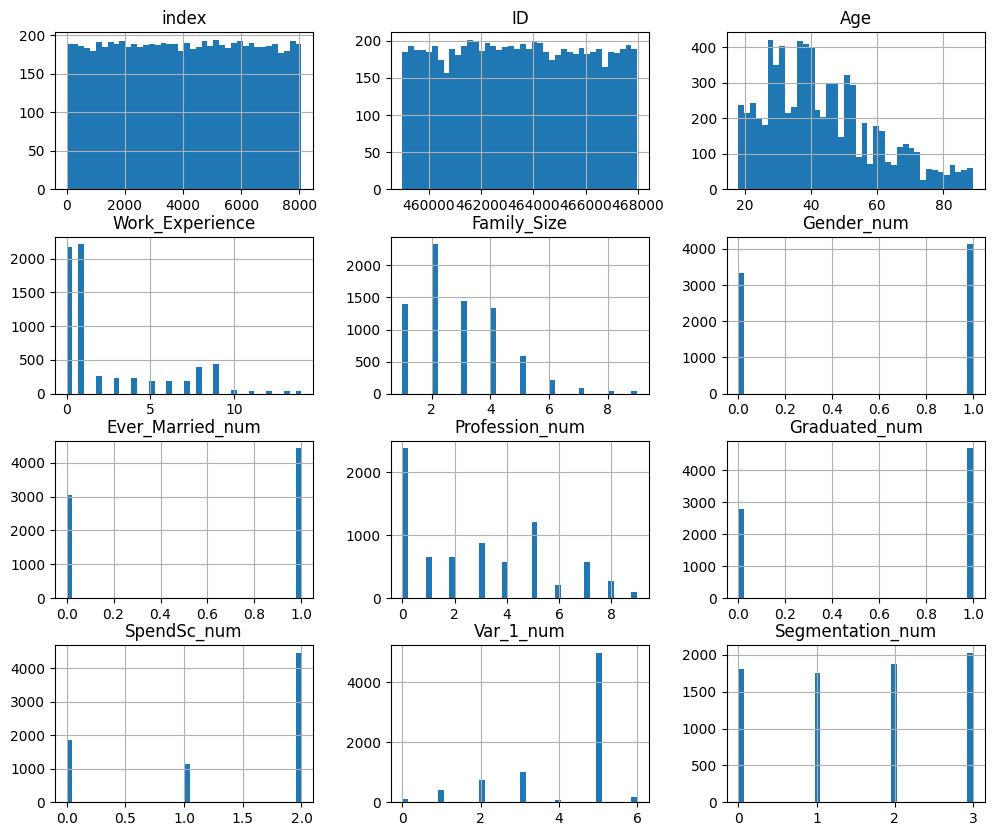

In [1213]:
# Visualise distibution of features now have added more
# histogram all numeric data to check data skews at a glance


df_cleaned.hist(bins=40, figsize=(12,10))
plt.tight_layout


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

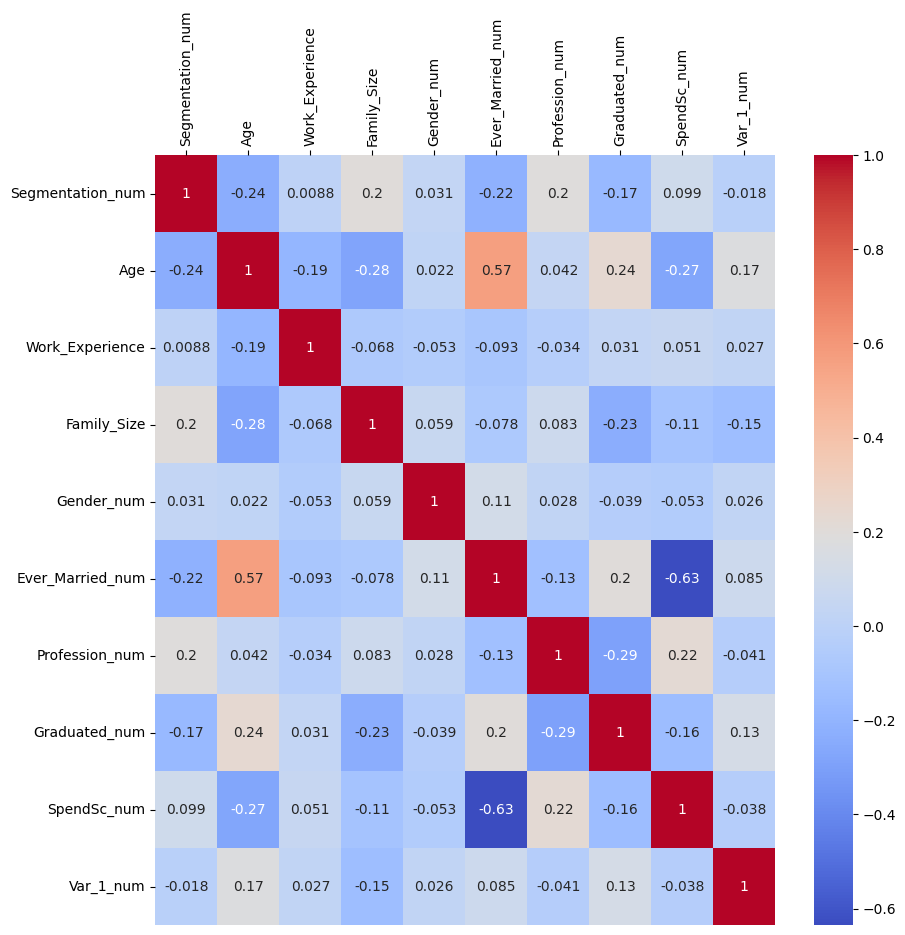

In [1214]:
# correlation matrix
plt.figure(figsize=(10,10))
corr_matrix = df_cleaned[["Segmentation_num","Age","Work_Experience","Family_Size","Gender_num","Ever_Married_num","Profession_num","Graduated_num","SpendSc_num","Var_1_num"]].corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout

# 3 Prepare modelling data - Feature scaling vs. normalisation and PCA
# 3.1 Create Modeling dataset

In [1215]:
# create modelling data set
# drop Segmentation and Segmentation_num as they are desired output for comparison and drop Work_experience as stated above
# drop categorical columns
model_data = df_cleaned.drop(['Ever_Married', 'Graduated',"Var_1","index","ID","Gender","Profession","Work_Experience","Spending_Score","Segmentation","Segmentation_num","agebin","Workexpbin"],axis = 1)
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7477 entries, 0 to 7476
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               7477 non-null   int64  
 1   Family_Size       7477 non-null   float64
 2   Gender_num        7477 non-null   int64  
 3   Ever_Married_num  7477 non-null   int64  
 4   Profession_num    7477 non-null   int64  
 5   Graduated_num     7477 non-null   int64  
 6   SpendSc_num       7477 non-null   int64  
 7   Var_1_num         7477 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 467.4 KB


# 3.2 Scale Data

In [ ]:
# feature scaling
# scaling method apply to same all columns
# robust scalar (extreme outliers, uses median instead of mean as per standard scaler)
sc = StandardScaler()
X_train_zscal = sc.fit_transform(model_data)
X_train_zscal  = pd.DataFrame(X_train_zscal, columns=model_data.columns)


mm = MinMaxScaler(feature_range=(0,10))
X_train_mm = mm.fit_transform(model_data)
X_train_mm  = pd.DataFrame(X_train_mm, columns=model_data.columns)

r = RobustScaler()
X_train_r = r.fit_transform(model_data)
X_train_r  = pd.DataFrame(X_train_r, columns=model_data.columns)

X_train_zscal 

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num
0,-1.295614,0.754838,0.899498,-1.205439,0.831061,-1.29909,0.765380,-0.825103
1,-0.332535,0.100925,-1.111731,0.829573,-0.316675,0.76977,-1.580008,-0.825103
2,1.413044,-1.206901,-1.111731,0.829573,-0.316675,0.76977,0.765380,0.590198
3,1.413044,-0.552988,0.899498,0.829573,1.596218,0.76977,-0.407314,0.590198
4,-0.212151,2.062663,-1.111731,0.829573,0.065904,0.76977,-0.407314,0.590198
...,...,...,...,...,...,...,...,...
7472,-1.295614,2.716576,0.899498,-1.205439,2.361375,-1.29909,0.765380,-2.948055
7473,-0.513113,0.754838,0.899498,-1.205439,0.448482,-1.29909,0.765380,-0.825103
7474,-0.633497,-1.206901,-1.111731,-1.205439,0.831061,0.76977,0.765380,0.590198
7475,-0.994652,0.754838,-1.111731,-1.205439,0.831061,0.76977,0.765380,0.590198


Charts below show scaling changes X axis but no major change to distribution or correlation of dataset


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

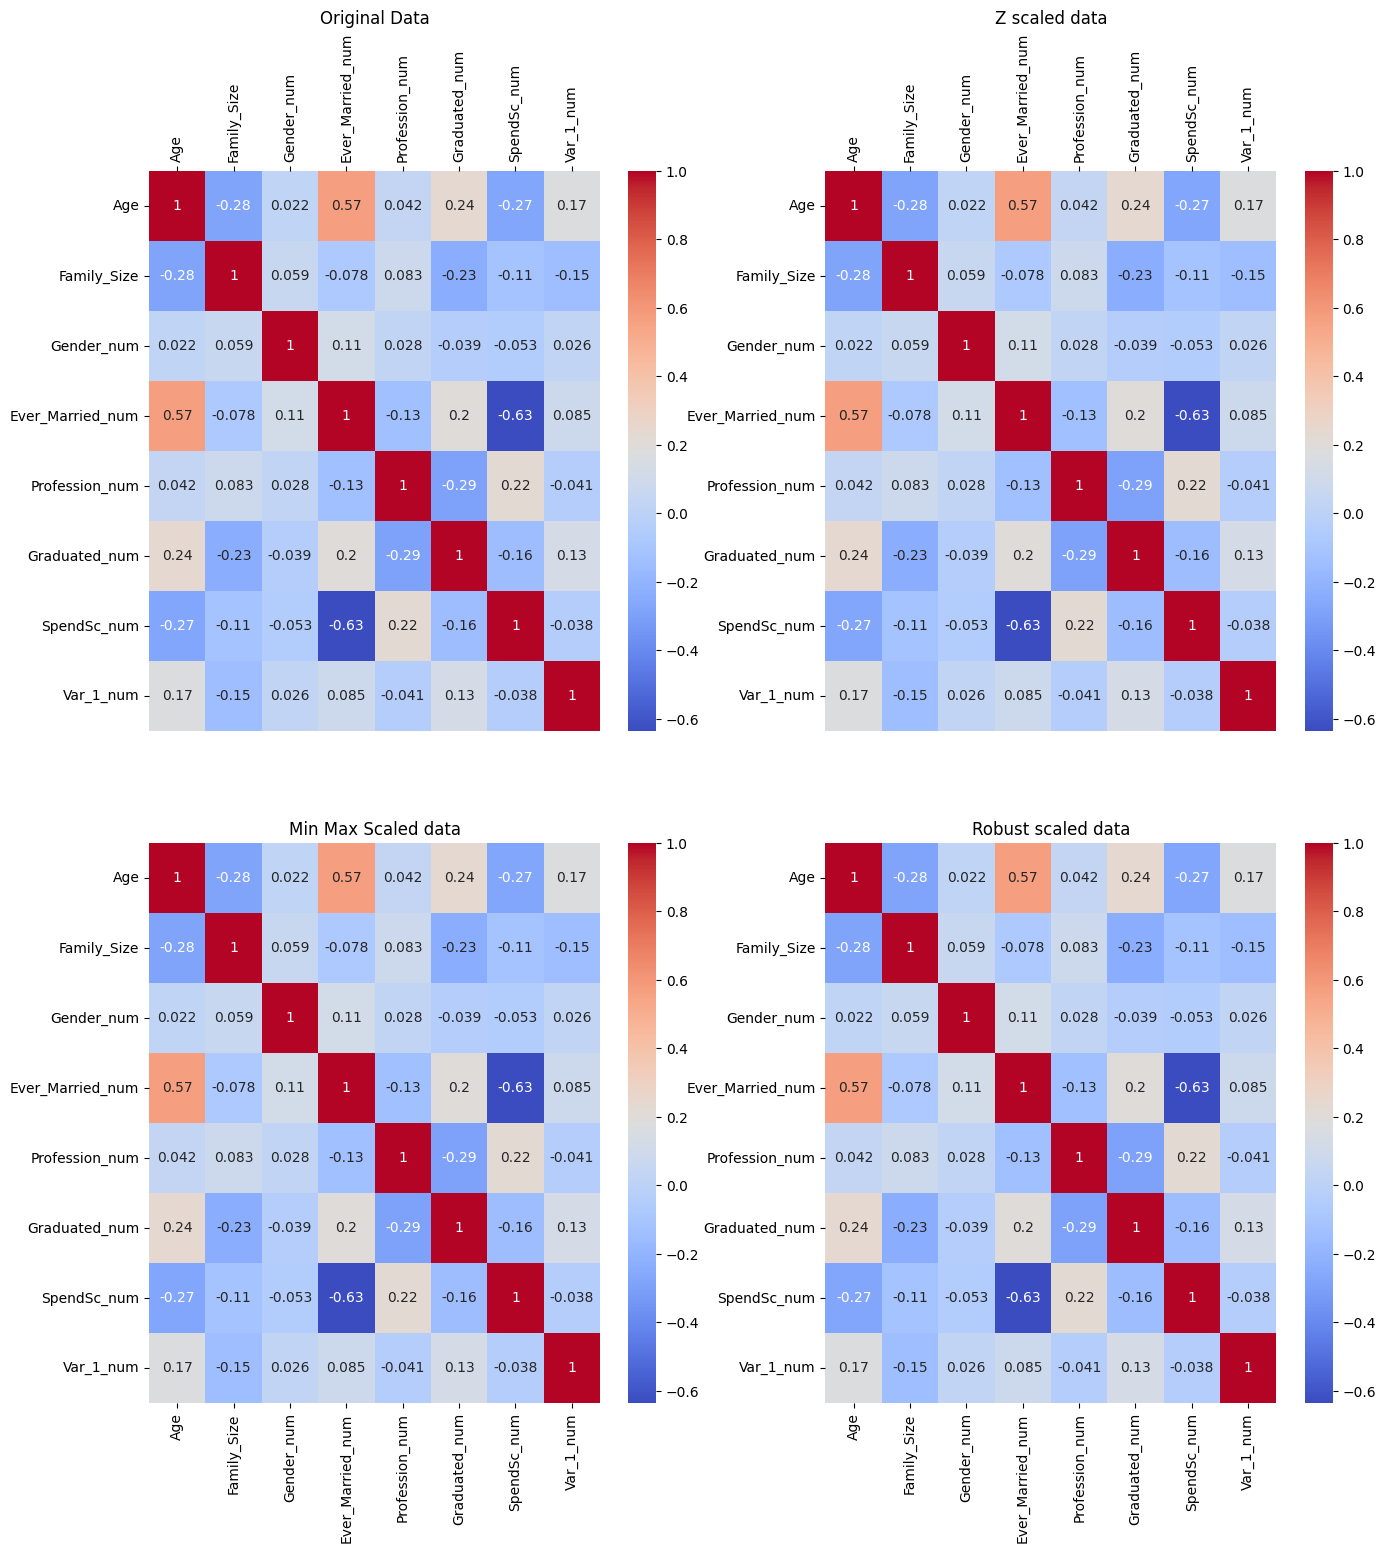

In [1217]:
# Plot original and scaled data
fig = plt.figure(figsize=(16,16))

ax = plt.subplot(2, 2, 1)
ax = plt.title('Original Data')
ax = corr_matrix = model_data.corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
ax = plt.xticks(rotation=90)


ax2 = plt.subplot(2, 2, 2)
ax2 = plt.title('Z scaled data')
ax2 = corr_matrix = X_train_zscal.corr()
ax2 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax2.xaxis.tick_top()
ax2 = plt.xticks(rotation=90)

ax3 = plt.subplot(2, 2, 3)
ax3 = plt.title('Min Max Scaled data')
ax3 = corr_matrix = X_train_mm.corr()
ax3 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")


ax4 = plt.subplot(2, 2, 4)
ax4 = plt.title('Robust scaled data')
ax4 = corr_matrix = X_train_r.corr()
ax4 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

plt.tight_layout


Blue is original data, red is zscaled, purple is robust scaled, orange is min max scaled


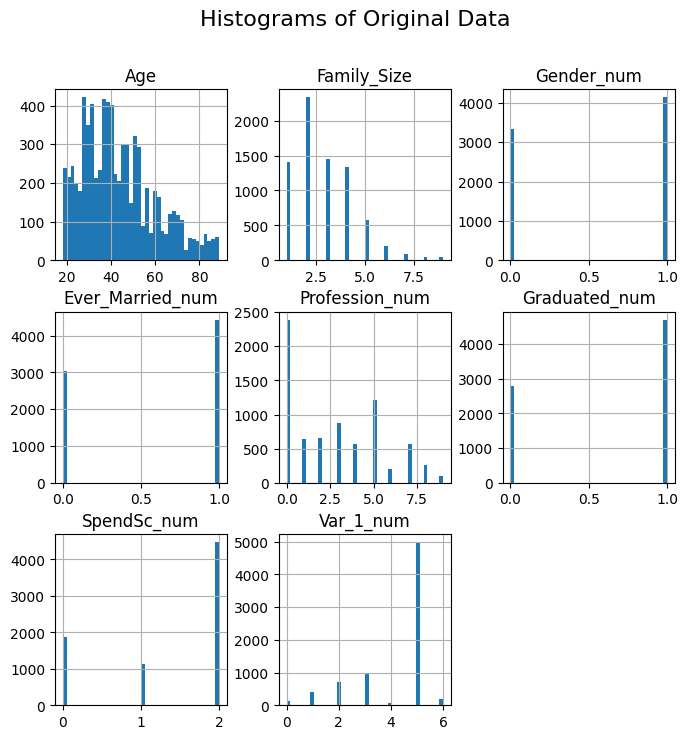

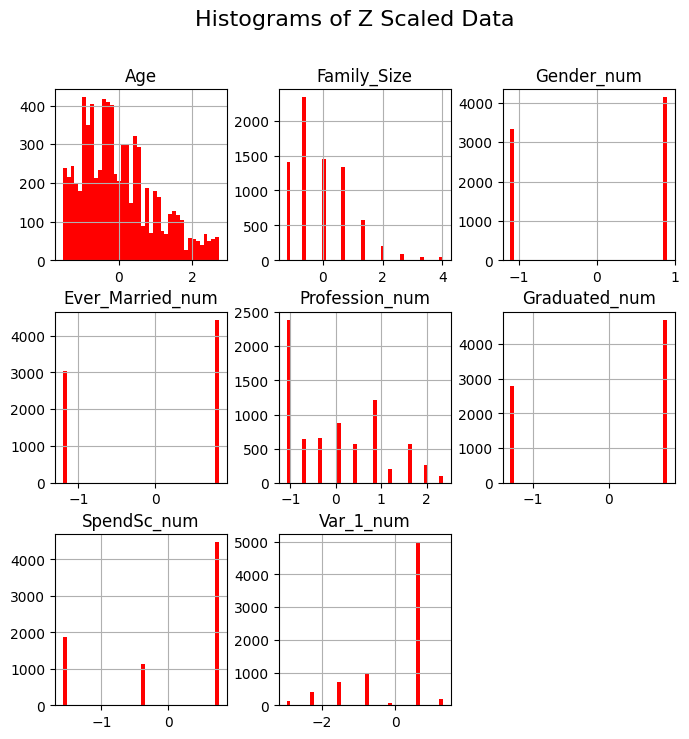

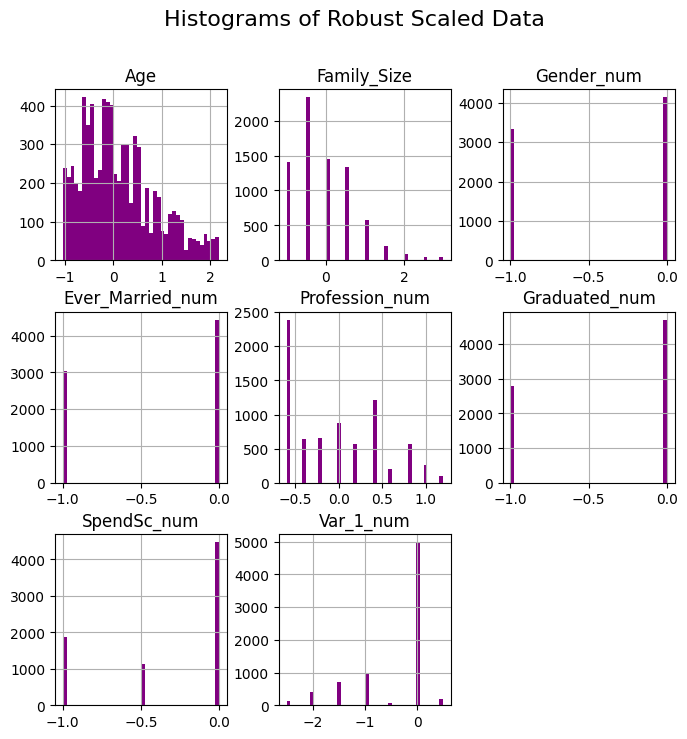

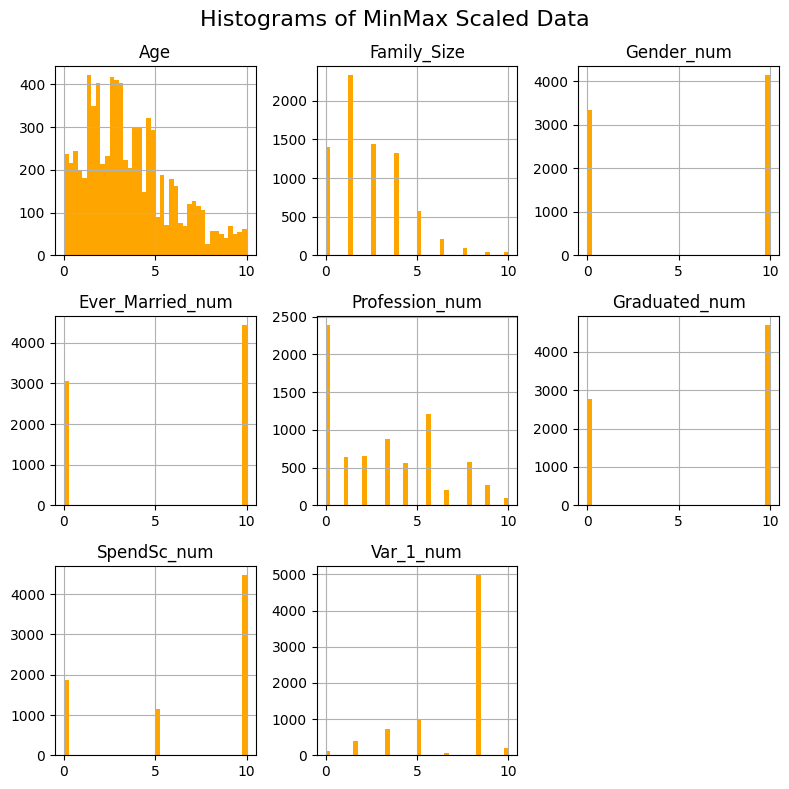

In [1218]:
# Plot original and scaled data
print("Blue is original data, red is zscaled, purple is robust scaled, orange is min max scaled")


model_data.hist(bins=40, figsize=(8,8))
plt.suptitle('Histograms of Original Data', fontsize=16)
X_train_zscal.hist(bins=40,  figsize=(8,8), color = "red")
plt.suptitle('Histograms of Z Scaled Data', fontsize=16)
X_train_r.hist(bins=40,  figsize=(8,8), color = "purple")
plt.suptitle('Histograms of Robust Scaled Data', fontsize=16)
X_train_mm.hist(bins=40,  figsize=(8,8), color = "orange")
plt.suptitle('Histograms of MinMax Scaled Data', fontsize=16)

plt.tight_layout()


# 3.3 Normalise 

Normalizer works on each sample (row) independently 
calculates the norm of each sample and then scales the individual features by dividing them by the computed norm. 
A regularization method, e.g. a method to keep the coefficients of the model small, and in turn, the model less complex.
- L1 Norm: aka Manhattan norm - sum of absolute values
- L2 Norm: aka Euclidean norm - square root of the sum of squared values – most common
- Max Norm: Scales each feature by the maximum absolute value in the sample – used neural network weights
References  - https://www.pythonprog.com/sklearn-preprocessing-normalizer/#:~:text=The%20Normalizer%20in%20Scikit-Learn%20focuses%20on%20transforming%20individual,values%20so%20they%20fall%20within%20a%20certain%20range.  https://machinelearningmastery.com/vector-norms-machine-learning/ 


In [1219]:
# Normalizer function - L2 Norm: Also known as the Euclidean norm, it’s the square root of the sum of squared values.
normalizerl2 = Normalizer(norm='l2')
# Apply the Normalizer 
X_norm_l2 = normalizerl2.fit_transform(model_data)
X_norm_l2  = pd.DataFrame(X_norm_l2, columns=model_data.columns)
X_norm_l2.head()

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num
0,0.947607,0.172292,0.043073,0.000000,0.215365,0.000000,0.086146,0.129219
1,0.991792,0.078299,0.000000,0.026100,0.052200,0.026100,0.000000,0.078299
2,0.996014,0.014866,0.000000,0.014866,0.029732,0.014866,0.029732,0.074329
3,0.990990,0.029582,0.014791,0.014791,0.103536,0.014791,0.014791,0.073954
4,0.977940,0.146691,0.000000,0.024448,0.073345,0.024448,0.024448,0.122242


In [1220]:
# Normalizer function L1 Norm: Also known as the Manhattan norm, it’s the sum of absolute values. 
normalizerl1 = Normalizer(norm='l1')
# Apply the Normalizer 
X_norm_l1 = normalizerl1.fit_transform(model_data)
X_norm_l1  = pd.DataFrame(X_norm_l1, columns=model_data.columns)
X_norm_l1.head()

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num
0,0.594595,0.108108,0.027027,0.000000,0.135135,0.000000,0.054054,0.081081
1,0.791667,0.062500,0.000000,0.020833,0.041667,0.020833,0.000000,0.062500
2,0.848101,0.012658,0.000000,0.012658,0.025316,0.012658,0.025316,0.063291
3,0.788235,0.023529,0.011765,0.011765,0.082353,0.011765,0.011765,0.058824
4,0.701754,0.105263,0.000000,0.017544,0.052632,0.017544,0.017544,0.087719


In [1221]:
# Normalizer function: Max Norm: Scales each feature by the maximum absolute value in the sample.
normalizermax = Normalizer(norm='max')
# Apply the Normalizer 
X_norm_mx = normalizermax.fit_transform(model_data)
X_norm_mx  = pd.DataFrame(X_norm_mx, columns=model_data.columns)
X_norm_mx.head()

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num
0,1.0,0.181818,0.045455,0.000000,0.227273,0.000000,0.090909,0.136364
1,1.0,0.078947,0.000000,0.026316,0.052632,0.026316,0.000000,0.078947
2,1.0,0.014925,0.000000,0.014925,0.029851,0.014925,0.029851,0.074627
3,1.0,0.029851,0.014925,0.014925,0.104478,0.014925,0.014925,0.074627
4,1.0,0.150000,0.000000,0.025000,0.075000,0.025000,0.025000,0.125000


In [1222]:
X_norm_mx.describe()

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num
count,7477.0,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000,7477.000000
mean,1.0,0.080401,0.014686,0.012653,0.078859,0.014820,0.038871,0.108378
std,0.0,0.063454,0.015442,0.011697,0.084991,0.012745,0.031674,0.055682
min,1.0,0.011236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.032787,0.000000,0.000000,0.000000,0.000000,0.000000,0.069444
50%,1.0,0.060606,0.014493,0.014493,0.057143,0.017241,0.038462,0.100000
75%,1.0,0.105263,0.025641,0.021739,0.115385,0.025000,0.062500,0.138889
max,1.0,0.500000,0.055556,0.055556,0.500000,0.055556,0.111111,0.333333


Charts below show major shifts to correlation and dataspread of dataset with normalisation. Normalization max in particular turns age from multi to single variable. 

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

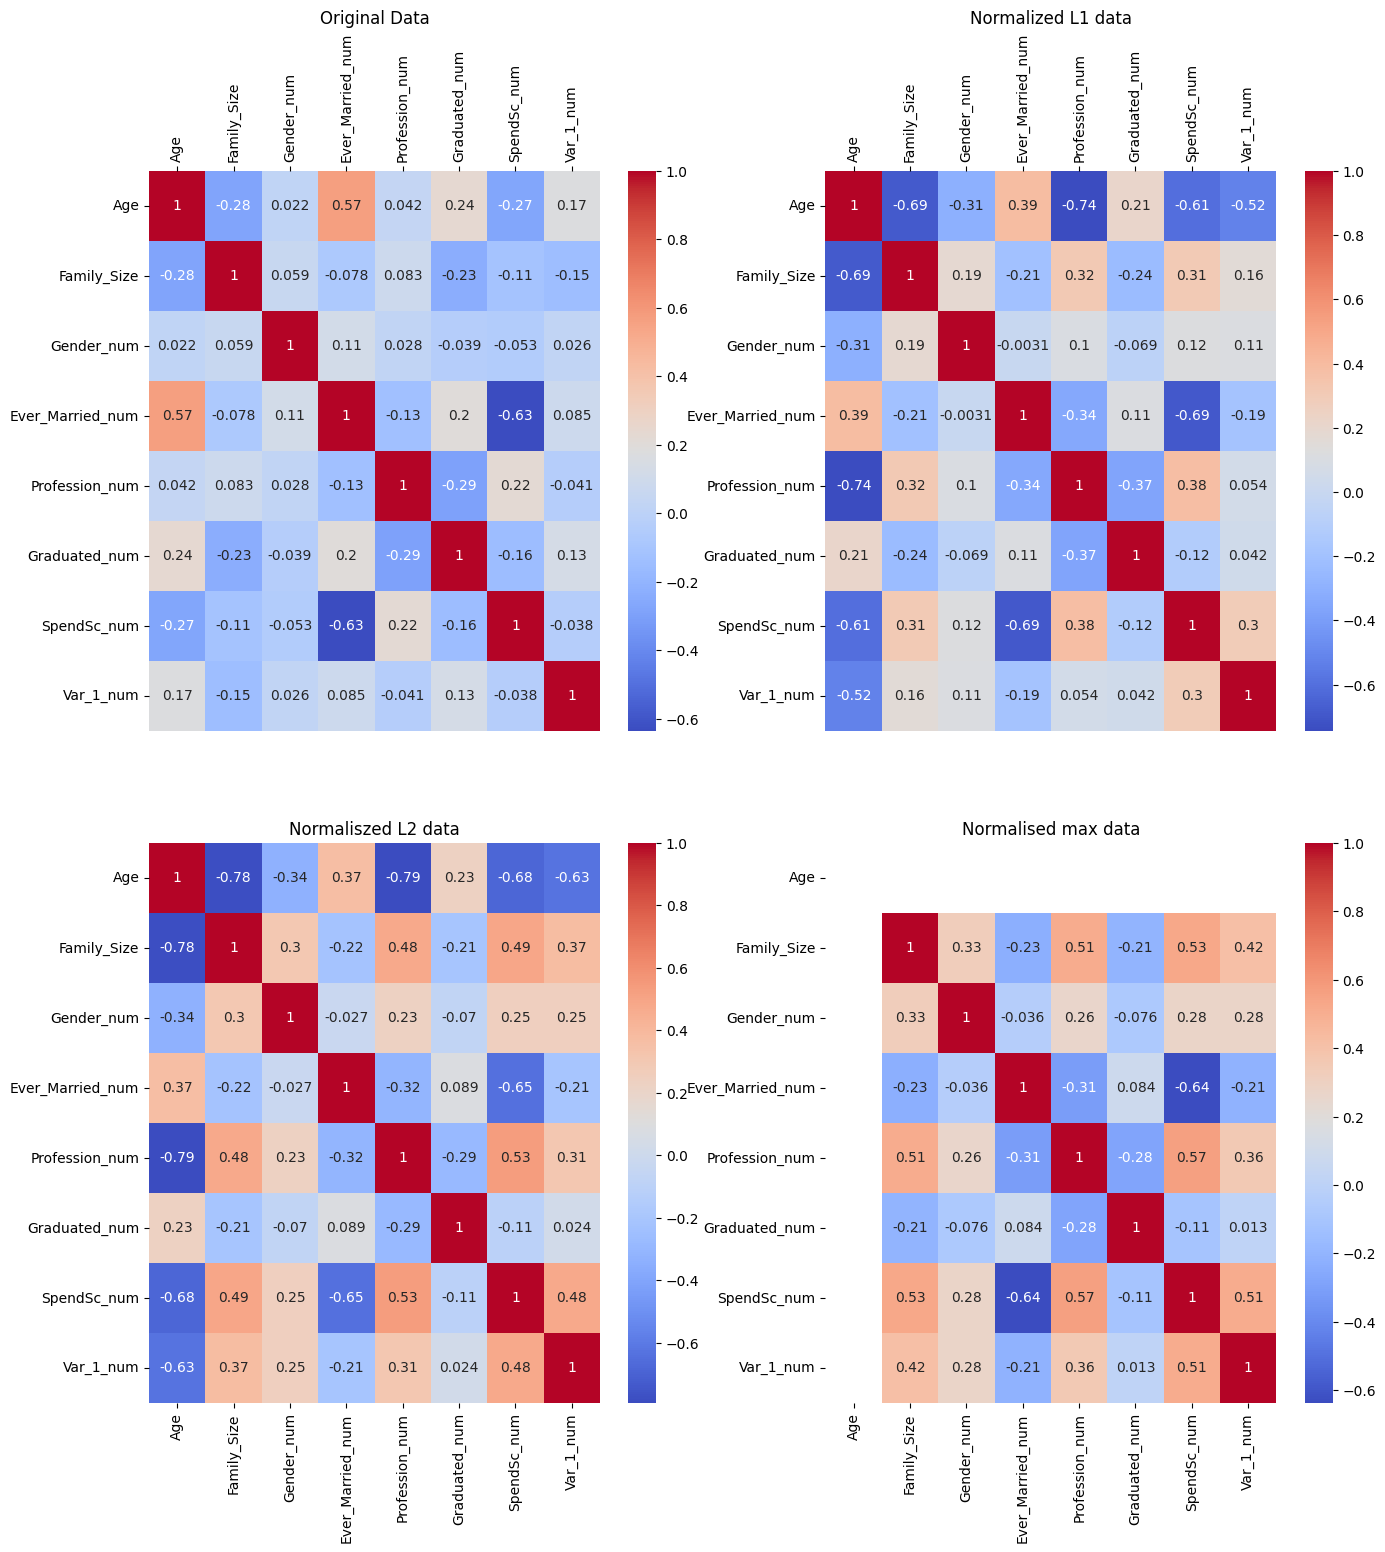

In [1223]:
# Plot original and normalized data
fig = plt.figure(figsize=(16,16))

ax = plt.subplot(2, 2, 1)
ax = plt.title('Original Data')
ax = corr_matrix = model_data.corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
ax = plt.xticks(rotation=90)


ax2 = plt.subplot(2, 2, 2)
ax2 = plt.title('Normalized L1 data')
ax2 = corr_matrix = X_norm_l1.corr()
ax2 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax2.xaxis.tick_top()
ax2 = plt.xticks(rotation=90)

ax3 = plt.subplot(2, 2, 3)
ax3 = plt.title('Normaliszed L2 data')
ax3 = corr_matrix = X_norm_l2.corr()
ax3 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")


ax4 = plt.subplot(2, 2, 4)
ax4 = plt.title('Normalised max data')
ax4 = corr_matrix = X_norm_mx.corr()
ax4 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

plt.tight_layout

Blue is original data, red is Normalized L1, purple is Normalized L2, orange is Normalized Max


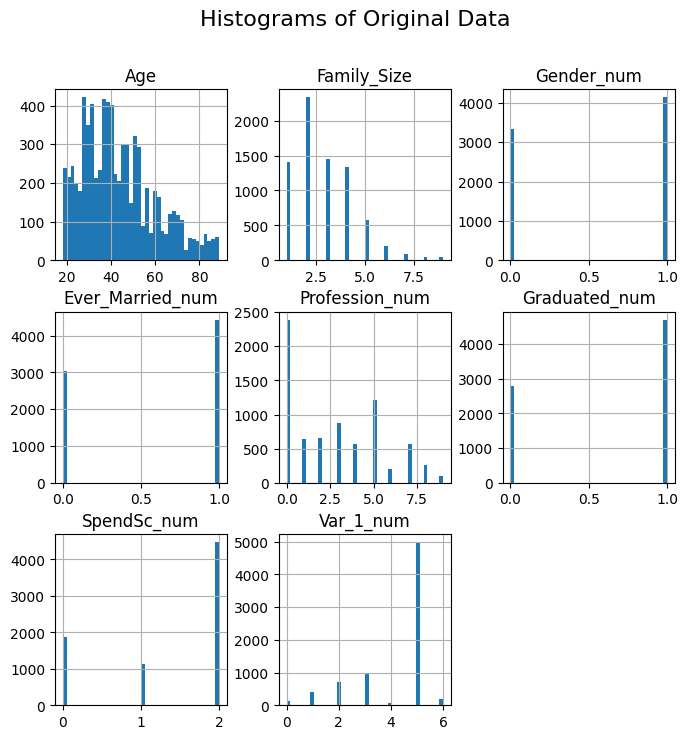

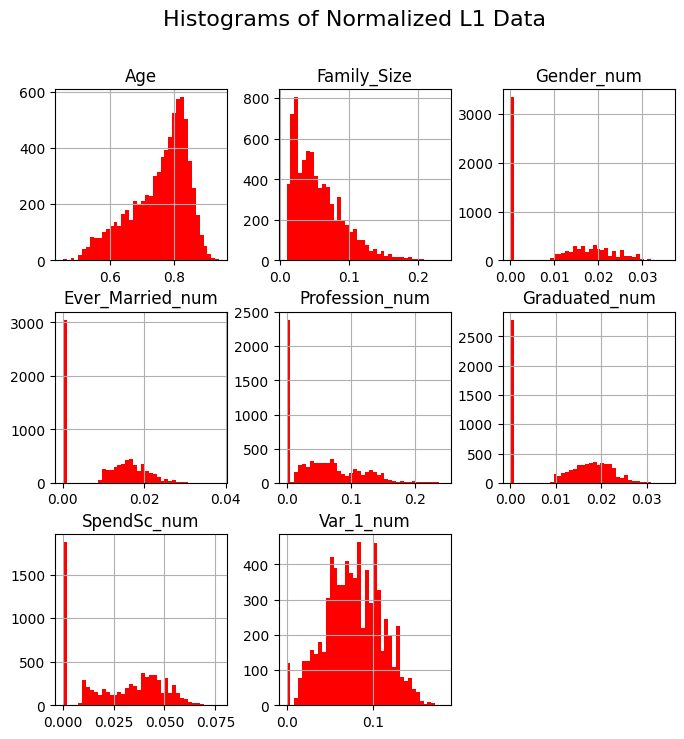

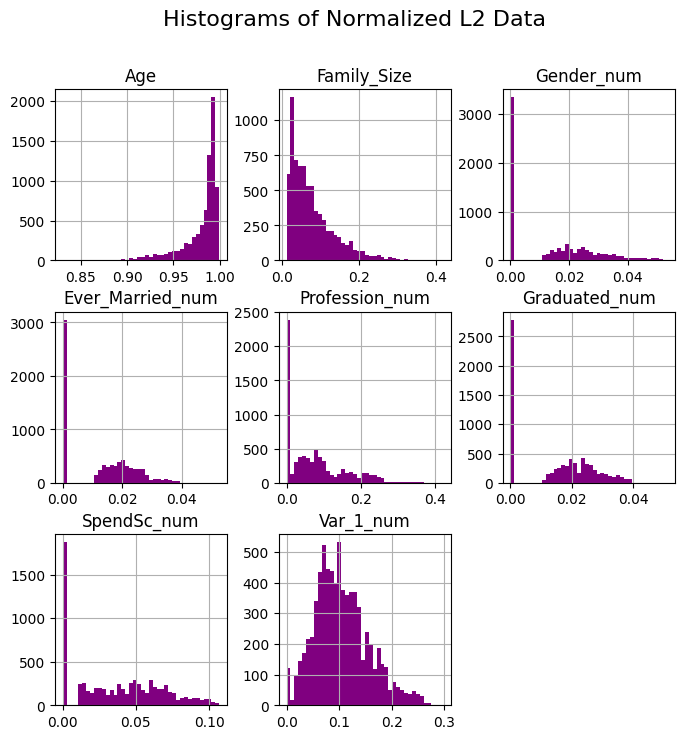

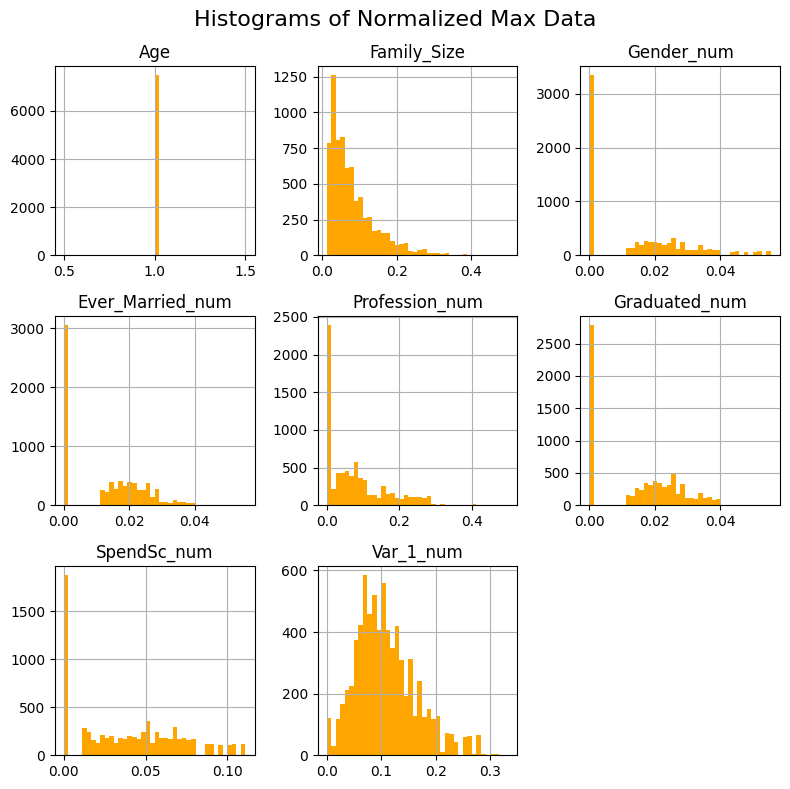

In [1224]:
# Plot original and normalized data
print("Blue is original data, red is Normalized L1, purple is Normalized L2, orange is Normalized Max")


model_data.hist(bins=40, figsize=(8,8))
plt.suptitle('Histograms of Original Data', fontsize=16)
X_norm_l1.hist(bins=40,  figsize=(8,8), color = "red")
plt.suptitle('Histograms of Normalized L1 Data', fontsize=16)
X_norm_l2.hist(bins=40,  figsize=(8,8), color = "purple")
plt.suptitle('Histograms of Normalized L2 Data', fontsize=16)
X_norm_mx.hist(bins=40,  figsize=(8,8), color = "orange")
plt.suptitle('Histograms of Normalized Max Data', fontsize=16)

plt.tight_layout()

# 3.4 PCA

In [1225]:
# dimensonality reduction PCA
n_components=2
pca = PCA(n_components)

reduced_data_orig = pca.fit_transform(model_data)
reduced_data_orig_table  = pd.DataFrame(reduced_data_orig)
reduced_data_orig_table.columns = ['PCA feat 1', 'PCA feat 2']
print(f"Original data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

reduced_data_orig_table.head()

Original data Varaiance Ratio: [0.95767885 0.02400603]
Variance covered by 2 component PCA covers 98.17 %


,PCA feat 1,PCA feat 2
0,-21.564696,2.438398
1,-5.518983,-0.898428
2,23.512936,-1.025036
3,23.534653,3.930564
4,-3.576957,0.323683


In [1226]:
reduced_data_orig

array([[-21.56469615,   2.43839786],
       [ -5.5189834 ,  -0.89842786],
       [ 23.51293645,  -1.0250361 ],
       ...,
       [-10.45910087,   2.04258099],
       [-16.53291807,   2.28649047],
       [ -6.50437664,   1.09026084]])

In [1227]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_Zscal = pca.fit_transform(X_train_zscal)
print(f"Z Scaled data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Z Scaled data Varaiance Ratio: [0.28155124 0.16775372 0.14542225]
Variance covered by 3 component PCA covers 59.47 %


In [1228]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_rscal = pca.fit_transform(X_train_r)
print(f"Robust Scaled data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Robust Scaled data Varaiance Ratio: [0.31220137 0.18316458 0.16023386]
Variance covered by 3 component PCA covers 65.56 %


In [1229]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_mmscal = pca.fit_transform(X_train_mm)
print(f"Min max Scaled data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Min max Scaled data Varaiance Ratio: [0.35045702 0.22567485 0.18205199]
Variance covered by 3 component PCA covers 75.82 %


In [1230]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_norml1 = pca.fit_transform(X_norm_l1)
print(f"L1 normalised data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")
print(f"L1 normalised data cumulative varaiance Ratio: {cumulative_var_ratio}")

L1 normalised data Varaiance Ratio: [0.77742037 0.11220763 0.06894253]
Variance covered by 3 component PCA covers 95.86 %
L1 normalised data cumulative varaiance Ratio: [0.77742037 0.889628   0.95857052]


In [1231]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_norml2 = pca.fit_transform(X_norm_l2)
print(f"L2 normalised data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

L2 normalised data Varaiance Ratio: [0.62096511 0.18411425 0.12837583]
Variance covered by 3 component PCA covers 93.35 %


In [1232]:
# dimensonality reduction PCA
n_components=3
pca = PCA(n_components)

reduced_data_normmax = pca.fit_transform(X_norm_mx)
print(f"Max normalised data Varaiance Ratio: {pca.explained_variance_ratio_}")
tot_perc = round(((np.sum(pca.explained_variance_ratio_, axis=0))*100),2)
print(f"Variance covered by {n_components} component PCA covers {tot_perc} %")

Max normalised data Varaiance Ratio: [0.63503947 0.17861237 0.12522699]
Variance covered by 3 component PCA covers 93.89 %


# 4 Modelling
# 4.1 K means clustering
Hartigan-Wongs algorithm not attempted would need to import HKMeans. Python automatically chooses the “best” algorithm either Elkan’s algorithm or Lloyd’s.

In [1233]:
# Generate dataframe to contain expected results and store model results
# specify this is a copy and not a view table to add further columns without error
results = df_cleaned[["ID","Segmentation","Segmentation_num"]].copy()
results.head()

,ID,Segmentation,Segmentation_num
0,462809,D,3
1,462643,A,0
2,466315,B,1
3,461735,B,1
4,462669,A,0


In [ ]:
# create shilouette score dataframe with one row
shilscore = pd.DataFrame(index=[0])
# set a cutoff column instead of the Segmentation_num column when comparing silhouette data in results using matrices. Cutoff determined as worked through shilouette scores and only that data saved to results table.
shilscore["cutoff"] = [0.29]
# set k column in case want to add further rows of different k numbers
shilscore["k"] = [4]

shilscore.head()

,cutoff,k
0,0.29,4


# 4.1.1 Original data

In [1235]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(model_data)
    sse.append(km.inertia_)
sse

[2158027.5757656815,
 748470.9169106572,
 392855.6370291199,
 252988.9003159974,
 192949.5529953484,
 166040.41477992773,
 130355.691037888,
 119365.4101426483,
 112156.56678510185]

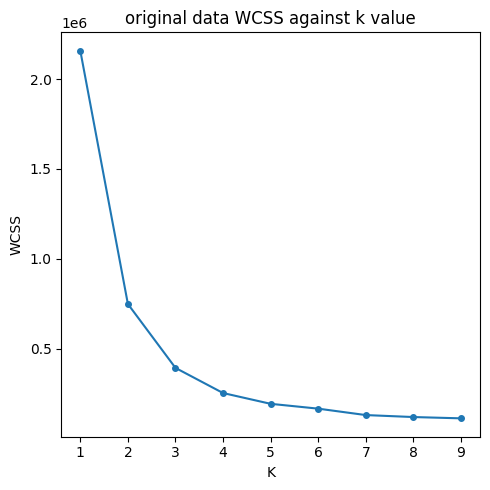

In [1236]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("original data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(model_data)

    score = silhouette_score(model_data, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(model_data)
score = silhouette_score(model_data, cluster_labels)
shilscore["Km Orig"] = score

shilscore.head()

Silhouette score for k = 2: 0.5510010956234674
Silhouette score for k = 3: 0.48202869017486133
Silhouette score for k = 4: 0.45213339538444125
Silhouette score for k = 5: 0.43009999848778596
Silhouette score for k = 6: 0.4146269074367189
Silhouette score for k = 7: 0.3889105858568971
Silhouette score for k = 8: 0.3353433661691314
Silhouette score for k = 9: 0.30243347588156344
Silhouette score for k = 10: 0.28258878493722794


,cutoff,k,Km Orig
0,0.29,4,0.452133


In [1238]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(model_data)

results["Km Orig"]= y_pred
# cPrint results
print("K Means Original WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()



K Means Original WCSS:  252988.9003159974
Iterations until converged:  13
Final Centroids: [[54.47433628  2.78643068  0.58584071  0.87610619  1.7699115   0.79941003
   0.94454277  4.30147493]
 [26.60171219  3.46351406  0.54178557  0.18059519  3.70892784  0.37953526
   1.81288219  3.92335915]
 [40.27442651  2.57561597  0.53101105  0.66737468  1.84324554  0.76338148
   1.1873407   4.12914189]
 [74.91179487  2.04615385  0.57538462  0.95384615  4.82666667  0.62769231
   1.2625641   4.62974359]]
Cluster assignment 
[1 2 3 ... 1 1 2]


,ID,Segmentation,Segmentation_num,Km Orig
0,462809,D,3,1
1,462643,A,0,2
2,466315,B,1,3
3,461735,B,1,3
4,462669,A,0,2


# 4.1.2 Robust scaled

In [1239]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_train_r)
    sse.append(km.inertia_)
sse

[21171.465600978005,
 16745.41108119993,
 14572.018210524075,
 12724.394926035417,
 11136.83303624453,
 10326.281956909883,
 9744.122580044437,
 9209.373676552732,
 8730.576781241884]

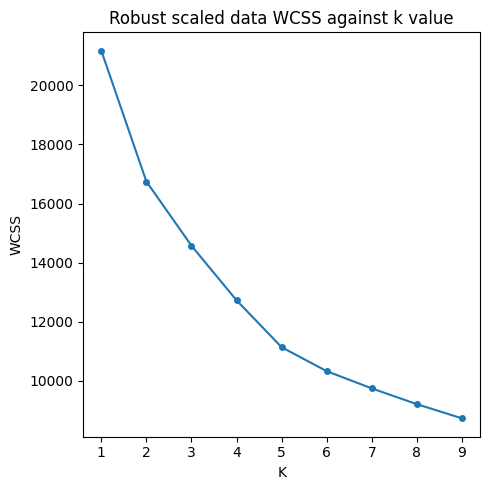

In [1240]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Robust scaled data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_train_r)

    score = silhouette_score(X_train_r, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_train_r)
score = silhouette_score(X_train_r, cluster_labels)
shilscore["Km RScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.20926990806266735
Silhouette score for k = 3: 0.16918714457282513
Silhouette score for k = 4: 0.19527150295977774
Silhouette score for k = 5: 0.20244644994671077
Silhouette score for k = 6: 0.20315267820663474
Silhouette score for k = 7: 0.20563789453058604
Silhouette score for k = 8: 0.2106665173324687
Silhouette score for k = 9: 0.19500885059864353
Silhouette score for k = 10: 0.19539206811148196


,cutoff,k,Km Orig,Km RScal
0,0.29,4,0.452133,0.195272


Won't use as doesn't elbow out and hoping to compare to category of 4

# 4.1.3 Z scaled

In [1242]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_train_zscal)
    sse.append(km.inertia_)
sse

[59816.0000000001,
 46224.5112631184,
 41035.067827637904,
 35794.30174356708,
 33243.94739099717,
 31050.785333354863,
 30029.274570597045,
 27330.348444905736,
 26207.424476087832]

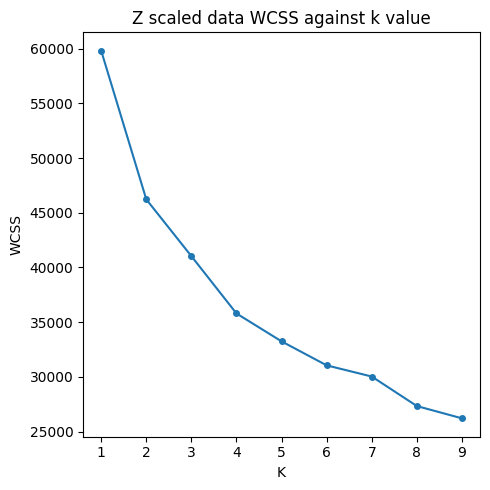

In [1243]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Z scaled data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_train_zscal)

    score = silhouette_score(X_train_zscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_train_zscal)
score = silhouette_score(X_train_zscal, cluster_labels)
shilscore["Km ZScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.226420445340063
Silhouette score for k = 3: 0.1851631057455191
Silhouette score for k = 4: 0.21481331724850106
Silhouette score for k = 5: 0.21626974047662487
Silhouette score for k = 6: 0.21565112088530755
Silhouette score for k = 7: 0.21107369517179345
Silhouette score for k = 8: 0.2076480342286167
Silhouette score for k = 9: 0.199700737855958
Silhouette score for k = 10: 0.20885453038230842


,cutoff,k,Km Orig,Km RScal,Km ZScal
0,0.29,4,0.452133,0.195272,0.214813


Won't use as doesn't elbow out and hoping to compare to category of 4

# 4.1.3 Max min scaled

In [1245]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_train_mm)
    sse.append(km.inertia_)
sse

[848806.8617136779,
 589676.5077211547,
 516469.6114991483,
 419246.30465246947,
 335868.1323843164,
 297217.10026207526,
 279461.5738319727,
 236214.2827293658,
 219136.9313028985]

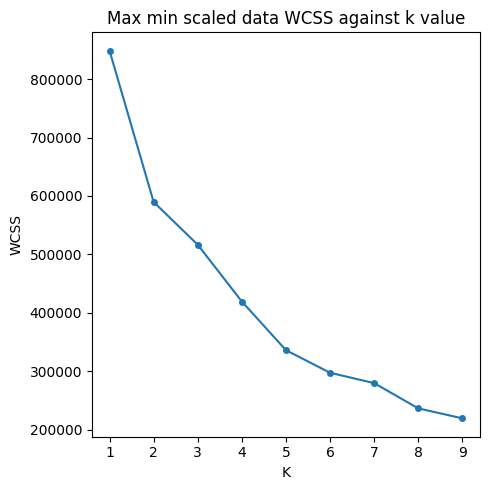

In [1246]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Max min scaled data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_train_mm)

    score = silhouette_score(X_train_mm, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_train_mm)
score = silhouette_score(X_train_mm, cluster_labels)
shilscore["Km MMScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.29864378999008095
Silhouette score for k = 3: 0.24943470090867154
Silhouette score for k = 4: 0.2903649816792524
Silhouette score for k = 5: 0.34602046169997436
Silhouette score for k = 6: 0.34786142934822073
Silhouette score for k = 7: 0.3517535928085673
Silhouette score for k = 8: 0.3994021137059826
Silhouette score for k = 9: 0.39374317727461067
Silhouette score for k = 10: 0.4086782660191969


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365


In [ ]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(X_train_mm)

results["Km MMScal"]= y_pred
# cPrint results 
print("K Means MMSCal WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means MMSCal WCSS:  419246.30465246947
Iterations until converged:  7
Final Centroids: [[ 4.67965607e+00  2.45188607e+00  6.31254811e+00  1.00000000e+01
   3.81575571e+00 -3.37507799e-14  4.85373364e+00  6.79240441e+00]
 [ 4.74982612e+00  2.00713735e+00  4.17443857e-14  1.00000000e+01
   2.22565158e+00  1.00000000e+01  4.23611111e+00  7.14377572e+00]
 [ 4.66624173e+00  2.11832061e+00  1.00000000e+01  1.00000000e+01
   2.54755846e+00  1.00000000e+01  4.41384951e+00  7.31188659e+00]
 [ 1.99715352e+00  2.48646654e+00  4.85236220e+00  9.59232693e-14
   3.60199767e+00  5.13451444e+00  1.00000000e+01  6.70056868e+00]]
Cluster assignment 
[3 1 1 ... 3 3 2]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal
0,462809,D,3,1,3
1,462643,A,0,2,1
2,466315,B,1,3,1
3,461735,B,1,3,2
4,462669,A,0,2,1


Won't use as doesn't elbow out and hoping to compare to category of 4

# 4.1.4 Normalised L2

In [1249]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_norm_l2)
    sse.append(km.inertia_)
sse

[107.38742088966839,
 58.291622181644634,
 49.425376355194686,
 42.58186169663696,
 36.485060835972455,
 33.58181064321613,
 30.422767450099684,
 28.603798630009962,
 26.909594809468558]

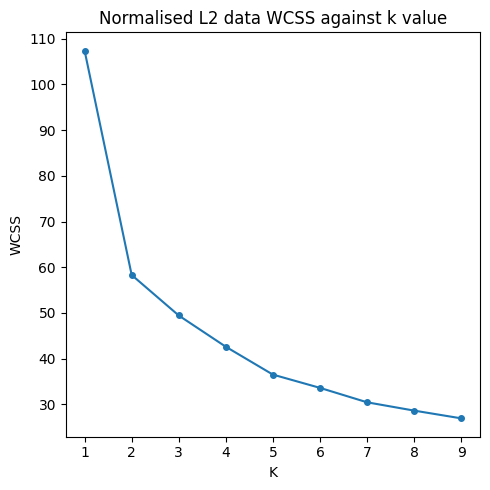

In [1250]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Normalised L2 data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_norm_l2)

    score = silhouette_score(X_norm_l2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_norm_l2)
score = silhouette_score(X_norm_l2, cluster_labels)
shilscore["Km NL2"] = score

shilscore.head()

Silhouette score for k = 2: 0.4811213640638967
Silhouette score for k = 3: 0.324907755124924
Silhouette score for k = 4: 0.291690035682987
Silhouette score for k = 5: 0.2567503005524911
Silhouette score for k = 6: 0.21544760939162383
Silhouette score for k = 7: 0.22598082131124955
Silhouette score for k = 8: 0.2226907573690424
Silhouette score for k = 9: 0.225987250471498
Silhouette score for k = 10: 0.23403972133466086


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169


In [1252]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(X_norm_l2)

results["Km NL2"]= y_pred
# cPrint results
print("K Means NormL2 WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means NormL2 WCSS:  42.58186169663696
Iterations until converged:  19
Final Centroids: [[0.99263017 0.0463755  0.01102436 0.01539551 0.03402559 0.01517942
  0.02218208 0.08105828]
 [0.93114944 0.18533272 0.02620841 0.00158459 0.22717282 0.00453541
  0.08365627 0.16679934]
 [0.97709771 0.11450513 0.01680113 0.011432   0.04008404 0.01747917
  0.04961608 0.14121636]
 [0.9722002  0.07780594 0.01511943 0.01063268 0.16097571 0.01633672
  0.04903426 0.11340354]]
Cluster assignment 
[1 0 0 ... 3 1 3]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2
0,462809,D,3,1,3,1
1,462643,A,0,2,1,0
2,466315,B,1,3,1,0
3,461735,B,1,3,2,0
4,462669,A,0,2,1,2


# 4.1.5 Normalised L1

In [1253]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_norm_l1)
    sse.append(km.inertia_)

sse

[103.74582013775343,
 45.13726760986145,
 34.01674570803317,
 29.3351218711097,
 25.69086468978442,
 22.948301723615845,
 21.067962029885088,
 19.783378088785078,
 18.472332961089833]

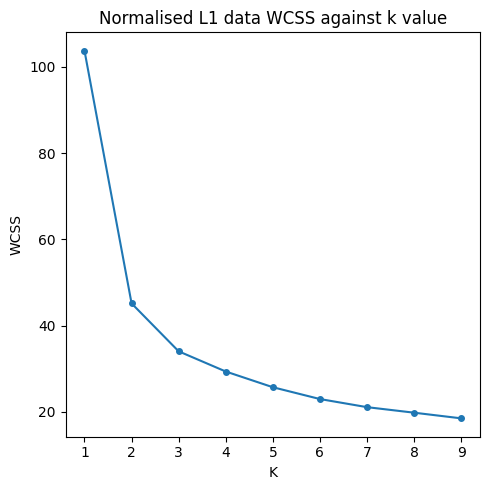

In [1254]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Normalised L1 data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_norm_l1)

    score = silhouette_score(X_norm_l1, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_norm_l1)
score = silhouette_score(X_norm_l1, cluster_labels)
shilscore["Km NL1"] = score

shilscore.head()

Silhouette score for k = 2: 0.4977309704163809
Silhouette score for k = 3: 0.34536547040027527
Silhouette score for k = 4: 0.26234830989916097
Silhouette score for k = 5: 0.26216401371465803
Silhouette score for k = 6: 0.2573403111048861
Silhouette score for k = 7: 0.25716466191379694
Silhouette score for k = 8: 0.2319061278305316
Silhouette score for k = 9: 0.24197435175666057
Silhouette score for k = 10: 0.24716203494128086


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348


Similar L2 slightly lower shilouette score but very sim

# 4.1.6 Normalised Max

In [1256]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(X_norm_mx)
    sse.append(km.inertia_)

sse

[118.80440871198208,
 63.71396875850239,
 53.45820262115187,
 46.30790467378511,
 39.77966896519547,
 36.27733022265879,
 33.258896125495696,
 31.278739069889617,
 29.692200003791772]

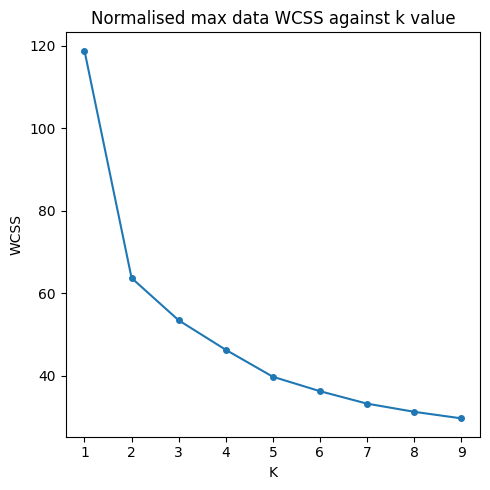

In [1257]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("Normalised max data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(X_norm_mx)

    score = silhouette_score(X_norm_mx, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(X_norm_mx)
score = silhouette_score(X_norm_mx, cluster_labels)
shilscore["Km NMx"] = score

shilscore.head()

Silhouette score for k = 2: 0.4949807697942167
Silhouette score for k = 3: 0.35073236990737944
Silhouette score for k = 4: 0.22517689642481645
Silhouette score for k = 5: 0.2558972370966112
Silhouette score for k = 6: 0.263809540311408
Silhouette score for k = 7: 0.22473138651159735
Silhouette score for k = 8: 0.2353970299804677
Silhouette score for k = 9: 0.2321112665037042
Silhouette score for k = 10: 0.23542786146393


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177


Similar L2 and have removed age. Slightly lower shilouette score

# 4.1.6 PCA original with cluster scatter plot

In [1259]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(reduced_data_orig)
    sse.append(km.inertia_)
sse

[2118503.0442942665,
 709052.9153100868,
 353535.1303886843,
 214161.58853599557,
 157080.2185730607,
 125374.89314091243,
 91847.48374392668,
 80549.04572313672,
 74284.56277288287]

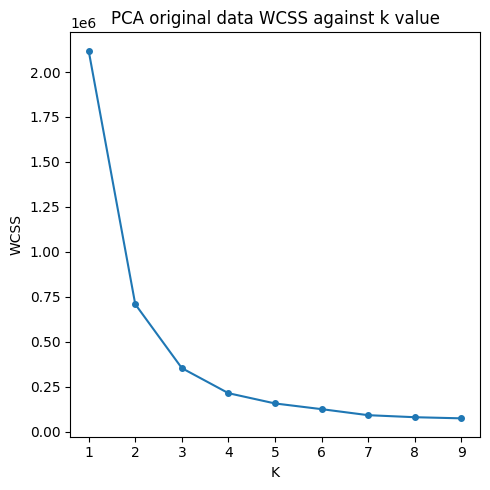

In [1260]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("PCA original data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(reduced_data_orig)

    score = silhouette_score(reduced_data_orig, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(reduced_data_orig)
score = silhouette_score(reduced_data_orig, cluster_labels)
shilscore["Km PCA Orig"] = score

shilscore.head()

Silhouette score for k = 2: 0.5716234396981728
Silhouette score for k = 3: 0.517773913431701
Silhouette score for k = 4: 0.503394705472688
Silhouette score for k = 5: 0.46988218850099883
Silhouette score for k = 6: 0.4243601665422799
Silhouette score for k = 7: 0.4737974413192701
Silhouette score for k = 8: 0.4296495666375876
Silhouette score for k = 9: 0.41766858846103294
Silhouette score for k = 10: 0.41562915780681114


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395


In [1262]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(reduced_data_orig)

results["Km PCA Orig"]= y_pred
# cPrint results
print("K Means PCA Orig WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.tail()

K Means PCA Orig WCSS:  214161.58853599557
Iterations until converged:  12
Final Centroids: [[ 10.94994247  -1.12991161]
 [-16.9342029    1.02424725]
 [ -3.23713319  -1.01041725]
 [ 31.41236195   1.82274313]]
Cluster assignment 
[1 2 3 ... 1 1 2]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig
7472,464018,D,3,1,3,1,1
7473,464685,D,3,2,3,3,2
7474,465406,D,3,1,3,3,1
7475,467299,B,1,1,3,1,1
7476,461879,B,1,2,2,3,2


,PCA feat 1,PCA feat 2,KmPCAOrig
0,-21.564696,2.438398,1
1,-5.518983,-0.898428,2
2,23.512936,-1.025036,3
3,23.534653,3.930564,3
4,-3.576957,0.323683,2
...,...,...,...
7472,-21.660221,6.750821,1
7473,-8.580821,1.423009,2
7474,-10.459101,2.042581,1
7475,-16.532918,2.286490,1


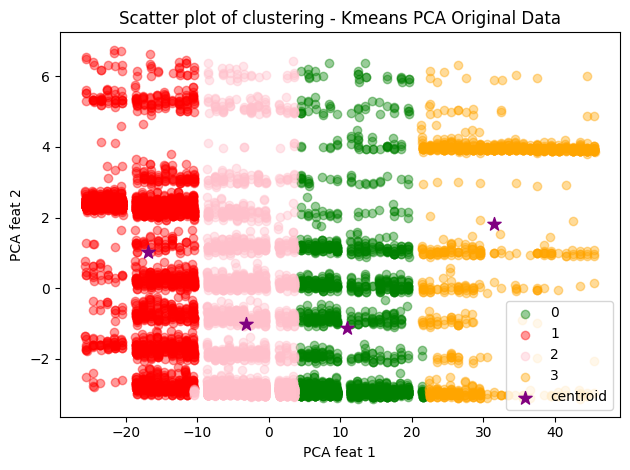

In [1263]:
# Scatter plot of clustering

reduced_data_orig_table["KmPCAOrig"] = results["Km PCA Orig"]

df1 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==0]
df2 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==1]
df3 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==2]
df4 = reduced_data_orig_table[reduced_data_orig_table.KmPCAOrig==3]

plt.scatter(df1["PCA feat 1"],df1["PCA feat 2"],color = "green", alpha=0.4, label = 0)
plt.scatter(df2["PCA feat 1"],df2["PCA feat 2"],color = "red",alpha=0.4, label = 1)
plt.scatter(df3["PCA feat 1"],df3["PCA feat 2"],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4["PCA feat 1"],df4["PCA feat 2"],color = "orange", alpha=0.4,label = 3)
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color = "purple", marker = "*", s = 100,label = "centroid")
plt.xlabel("PCA feat 1")
plt.ylabel("PCA feat 2")
plt.legend()
plt.title("Scatter plot of clustering - Kmeans PCA Original Data")
plt.tight_layout()

reduced_data_orig_table

# 4.1.7 PCA Max Min scaled 

In [1264]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(reduced_data_mmscal)
    sse.append(km.inertia_)
sse

[643551.6541046696,
 449297.6180719179,
 311374.9889518364,
 221518.87702049763,
 158905.71720647212,
 120446.2489441979,
 86882.81651240327,
 34363.64962352447,
 26932.42873144886]

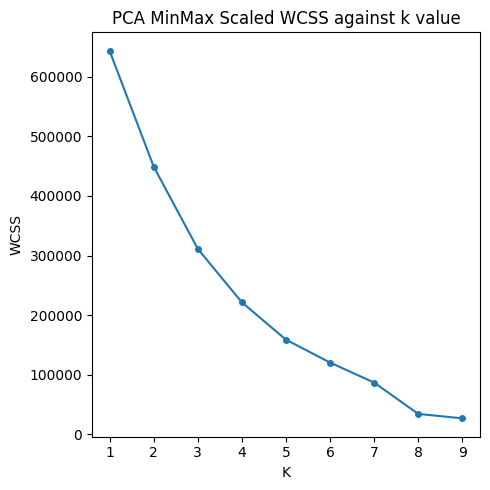

In [1265]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("PCA MinMax Scaled WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(reduced_data_mmscal)

    score = silhouette_score(reduced_data_mmscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(reduced_data_mmscal)
score = silhouette_score(reduced_data_mmscal, cluster_labels)
shilscore["Km PCA MMScal"] = score

shilscore.head()

Silhouette score for k = 2: 0.34700436864117196
Silhouette score for k = 3: 0.405916569940635
Silhouette score for k = 4: 0.48032951421926673
Silhouette score for k = 5: 0.5450264685928927
Silhouette score for k = 6: 0.6057553083453547
Silhouette score for k = 7: 0.664460129535623
Silhouette score for k = 8: 0.760226856412453
Silhouette score for k = 9: 0.7567231485454967
Silhouette score for k = 10: 0.7465944121723774


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033


In [1267]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(reduced_data_mmscal)

results["Km PCA MMScal"]= y_pred
# cPrint results
print("K Means PCA MMScal WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means PCA MMScal WCSS:  221518.87702049763
Iterations until converged:  4
Final Centroids: [[-2.96955413  6.93679013 -2.35673348]
 [ 6.45079153  2.40714375  3.12569967]
 [-6.28953674 -3.00222792  2.06437024]
 [ 4.04281078 -4.95654802 -3.72706719]]
Cluster assignment 
[0 3 3 ... 2 2 1]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal
0,462809,D,3,1,3,1,1,0
1,462643,A,0,2,1,0,2,3
2,466315,B,1,3,1,0,3,3
3,461735,B,1,3,2,0,3,1
4,462669,A,0,2,1,2,2,3


# 4.1.8 PCA L2 norm

In [1268]:
## finding the k value - elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 42)
    km.fit(reduced_data_norml2)
    sse.append(km.inertia_)
sse

[100.2413454005869,
 51.15359682630388,
 42.39611064674612,
 35.569842856718736,
 29.5502213182155,
 26.510396971506438,
 23.649392815685985,
 21.871311907377024,
 20.390658811041387]

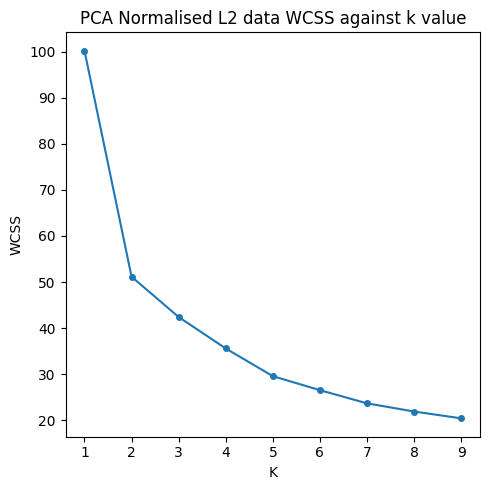

In [1269]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("WCSS")
plt.xlabel("K")
plt.title("PCA Normalised L2 data WCSS against k value")
plt.tight_layout()

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = KMeans(n_clusters=k,random_state = 42)
    cluster_labels = cluster.fit_predict(reduced_data_norml2)

    score = silhouette_score(reduced_data_norml2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster = KMeans(n_clusters=4,random_state = 42)
cluster_labels = cluster.fit_predict(reduced_data_norml2)
score = silhouette_score(reduced_data_norml2, cluster_labels)
shilscore["Km PCA NL2"] = score

shilscore.head()

Silhouette score for k = 2: 0.5123316170449252
Silhouette score for k = 3: 0.37435076711105164
Silhouette score for k = 4: 0.31989216048232477
Silhouette score for k = 5: 0.30820163835657555
Silhouette score for k = 6: 0.3169916596777637
Silhouette score for k = 7: 0.282518228938596
Silhouette score for k = 8: 0.286285862402081
Silhouette score for k = 9: 0.28880787479967396
Silhouette score for k = 10: 0.28881514620400667


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892


In [1271]:
# implement algorithm again
km = KMeans(n_clusters=4, random_state = 42)
y_pred = km.fit_predict(reduced_data_norml2)

results["Km PCA NL2"]= y_pred
# cPrint results
print("K Means NormL1 WCSS: ", km.inertia_)
print("Iterations until converged: ", km.n_iter_)
print(f"Final Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)

results.head()

K Means NormL1 WCSS:  35.569842856718736
Iterations until converged:  14
Final Centroids: [[-0.06066529 -0.01019098  0.0013082 ]
 [ 0.20730705  0.0146229   0.01107769]
 [ 0.07687142 -0.04490906 -0.01847538]
 [ 0.00152207  0.0591144   0.00452907]]
Cluster assignment 
[1 0 0 ... 2 1 0]


,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2
0,462809,D,3,1,3,1,1,0,1
1,462643,A,0,2,1,0,2,3,0
2,466315,B,1,3,1,0,3,3,0
3,461735,B,1,3,2,0,3,1,0
4,462669,A,0,2,1,2,2,3,3


# 4.2 Hierarchical clustering
# 4.2.1 Original data 

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(model_data)

    score = silhouette_score(model_data, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(model_data)
score = silhouette_score(model_data, cluster_labels)
shilscore["Aggl Orig"] = score

shilscore.head()


Silhouette score for k = 2: 0.5387441276333904
Silhouette score for k = 3: 0.4945836545379977
Silhouette score for k = 4: 0.4346281213016325
Silhouette score for k = 5: 0.40542256442997315
Silhouette score for k = 6: 0.41458869402349235
Silhouette score for k = 7: 0.38923598719033625
Silhouette score for k = 8: 0.33923906513332436
Silhouette score for k = 9: 0.29541298995281473
Silhouette score for k = 10: 0.26746181362361293


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628


In [1273]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(model_data)
results["Aggl Orig"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig
0,462809,D,3,1,3,1,1,0,1,1
1,462643,A,0,2,1,0,2,3,0,3
2,466315,B,1,3,1,0,3,3,0,2
3,461735,B,1,3,2,0,3,1,0,2
4,462669,A,0,2,1,2,2,3,3,3


Optimal is 2 clusters but will force 4 to try to hit target data

# 4.2.2 Scaled data

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_train_r)

    score = silhouette_score(X_train_r, cluster_labels)
    sil_score.append(score)
    print(f"Robust Scalar - Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_train_r)
score = silhouette_score(X_train_r, cluster_labels)
shilscore["Aggl RScal"] = score

shilscore.head()

Robust Scalar - Silhouette score for k = 2: 0.17528310268471547
Robust Scalar - Silhouette score for k = 3: 0.17600232530692875
Robust Scalar - Silhouette score for k = 4: 0.1521398905397797
Robust Scalar - Silhouette score for k = 5: 0.14004898103457106
Robust Scalar - Silhouette score for k = 6: 0.16297526613205082
Robust Scalar - Silhouette score for k = 7: 0.16172240007469002
Robust Scalar - Silhouette score for k = 8: 0.17357852442075575
Robust Scalar - Silhouette score for k = 9: 0.1766399739897777
Robust Scalar - Silhouette score for k = 10: 0.16238666817762312


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628,0.15214


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_train_zscal)

    score = silhouette_score(X_train_zscal, cluster_labels)
    sil_score.append(score)
    print(f"Z Scale - Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_train_zscal)
score = silhouette_score(X_train_zscal, cluster_labels)
shilscore["Aggl ZScal"] = score
shilscore.head()

Z Scale - Silhouette score for k = 2: 0.20839228285178207
Z Scale - Silhouette score for k = 3: 0.17665226477041437
Z Scale - Silhouette score for k = 4: 0.18863585054826817
Z Scale - Silhouette score for k = 5: 0.1793386274647525
Z Scale - Silhouette score for k = 6: 0.18243446854071685
Z Scale - Silhouette score for k = 7: 0.19191786504014496
Z Scale - Silhouette score for k = 8: 0.1771576728250597
Z Scale - Silhouette score for k = 9: 0.18150993386073405
Z Scale - Silhouette score for k = 10: 0.1728989217199293


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628,0.15214,0.188636


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_train_mm)

    score = silhouette_score(X_train_mm, cluster_labels)
    sil_score.append(score)
    print(f"Min max Scale - Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_train_mm)
score = silhouette_score(X_train_mm, cluster_labels)
shilscore["Aggl MMScal"] = score
shilscore.head()

Min max Scale - Silhouette score for k = 2: 0.29864378999008095
Min max Scale - Silhouette score for k = 3: 0.2835441981031218
Min max Scale - Silhouette score for k = 4: 0.31180468238220194
Min max Scale - Silhouette score for k = 5: 0.34602046169997436
Min max Scale - Silhouette score for k = 6: 0.34786142934822073
Min max Scale - Silhouette score for k = 7: 0.3879714389205893
Min max Scale - Silhouette score for k = 8: 0.3840416567791085
Min max Scale - Silhouette score for k = 9: 0.4156625525995219
Min max Scale - Silhouette score for k = 10: 0.42741739117125566


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628,0.15214,0.188636,0.311805


In [1277]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_train_mm)
results["Aggl MMScal"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal
0,462809,D,3,1,3,1,1,0,1,1,3
1,462643,A,0,2,1,0,2,3,0,3,0
2,466315,B,1,3,1,0,3,3,0,2,0
3,461735,B,1,3,2,0,3,1,0,2,0
4,462669,A,0,2,1,2,2,3,3,3,0




# 4.2.3 Normalisation L2

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_norm_l2)

    score = silhouette_score(X_norm_l2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_norm_l2)
score = silhouette_score(X_norm_l2, cluster_labels)
shilscore["Aggl NL2"] = score
shilscore.head()

Silhouette score for k = 2: 0.44393845474061816
Silhouette score for k = 3: 0.3572367061739621
Silhouette score for k = 4: 0.19851103016891294
Silhouette score for k = 5: 0.2063408181702902
Silhouette score for k = 6: 0.21237764310994406
Silhouette score for k = 7: 0.22286277836319426
Silhouette score for k = 8: 0.17576753449730248
Silhouette score for k = 9: 0.1757214684037106
Silhouette score for k = 10: 0.1681501270393505


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628,0.15214,0.188636,0.311805,0.198511


In [1279]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_norm_l2)
results["Aggl NL2"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2
0,462809,D,3,1,3,1,1,0,1,1,3,2
1,462643,A,0,2,1,0,2,3,0,3,0,1
2,466315,B,1,3,1,0,3,3,0,2,0,1
3,461735,B,1,3,2,0,3,1,0,2,0,1
4,462669,A,0,2,1,2,2,3,3,3,0,1


Very poor performance at 4 clusters. Ran anyway to compare to K means. poorer than minmax scalar

# 4.2.3 Normalisation L1

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_norm_l1)

    score = silhouette_score(X_norm_l1, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_norm_l1)
score = silhouette_score(X_norm_l1, cluster_labels)
shilscore["Aggl NL1"] = score
shilscore.head()

Silhouette score for k = 2: 0.45095252967560623
Silhouette score for k = 3: 0.3362855216149935
Silhouette score for k = 4: 0.32833020763011367
Silhouette score for k = 5: 0.16896951153051917
Silhouette score for k = 6: 0.1782355458880267
Silhouette score for k = 7: 0.1686466131121687
Silhouette score for k = 8: 0.16319109464647258
Silhouette score for k = 9: 0.16748368794009194
Silhouette score for k = 10: 0.17336364378973113


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628,0.15214,0.188636,0.311805,0.198511,0.32833


In [1281]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_norm_l1)
results["Aggl NL1"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1
0,462809,D,3,1,3,1,1,0,1,1,3,2,1
1,462643,A,0,2,1,0,2,3,0,3,0,1,0
2,466315,B,1,3,1,0,3,3,0,2,0,1,0
3,461735,B,1,3,2,0,3,1,0,2,0,1,0
4,462669,A,0,2,1,2,2,3,3,3,0,1,2


# 4.2.3 Normalisation Max


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(X_norm_mx)

    score = silhouette_score(X_norm_mx, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(X_norm_mx)
score = silhouette_score(X_norm_mx, cluster_labels)
shilscore["Aggl NMx"] = score
shilscore.head()

Silhouette score for k = 2: 0.39754076200203003
Silhouette score for k = 3: 0.3542358049274531
Silhouette score for k = 4: 0.34960250378251706
Silhouette score for k = 5: 0.19172525097372828
Silhouette score for k = 6: 0.20531541099611414
Silhouette score for k = 7: 0.1685427868271294
Silhouette score for k = 8: 0.15983186254354825
Silhouette score for k = 9: 0.16177223879086086
Silhouette score for k = 10: 0.16726109983516196


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628,0.15214,0.188636,0.311805,0.198511,0.32833,0.349603


In [1283]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(X_norm_mx)
results["Aggl NMx"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx
0,462809,D,3,1,3,1,1,0,1,1,3,2,1,1
1,462643,A,0,2,1,0,2,3,0,3,0,1,0,0
2,466315,B,1,3,1,0,3,3,0,2,0,1,0,0
3,461735,B,1,3,2,0,3,1,0,2,0,1,0,0
4,462669,A,0,2,1,2,2,3,3,3,0,1,2,3


# 4.2.4 PCA Original with cluster scatter plot


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_orig)

    score = silhouette_score(reduced_data_orig, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_orig)
score = silhouette_score(reduced_data_orig, cluster_labels)
shilscore["Aggl PCA Orig"] = score
shilscore.head()

Silhouette score for k = 2: 0.560841800185775
Silhouette score for k = 3: 0.5256064201505989
Silhouette score for k = 4: 0.487562220473095
Silhouette score for k = 5: 0.4731861688667006
Silhouette score for k = 6: 0.48642646111500437
Silhouette score for k = 7: 0.47578960061706754
Silhouette score for k = 8: 0.42013966074701453
Silhouette score for k = 9: 0.4087487765519626
Silhouette score for k = 10: 0.39016046147553746


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,0.48033,0.319892,0.434628,0.15214,0.188636,0.311805,0.198511,0.32833,0.349603,0.487562


In [1285]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(reduced_data_orig)
results["Aggl PCA Orig"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig
0,462809,D,3,1,3,1,1,0,1,1,3,2,1,1,1
1,462643,A,0,2,1,0,2,3,0,3,0,1,0,0,3
2,466315,B,1,3,1,0,3,3,0,2,0,1,0,0,2
3,461735,B,1,3,2,0,3,1,0,2,0,1,0,0,2
4,462669,A,0,2,1,2,2,3,3,3,0,1,2,3,3


,PCA feat 1,PCA feat 2,KmPCAOrig,AgglPCAOrig
0,-21.564696,2.438398,1,1
1,-5.518983,-0.898428,2,3
2,23.512936,-1.025036,3,2
3,23.534653,3.930564,3,2
4,-3.576957,0.323683,2,3
...,...,...,...,...
7472,-21.660221,6.750821,1,1
7473,-8.580821,1.423009,2,3
7474,-10.459101,2.042581,1,1
7475,-16.532918,2.286490,1,1


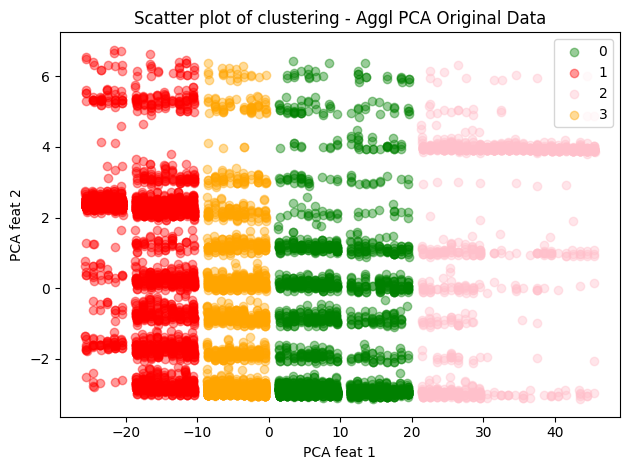

In [1286]:
# Scatter plot of clustering

reduced_data_orig_table["AgglPCAOrig"] = results["Aggl PCA Orig"]

df1 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==0]
df2 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==1]
df3 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==2]
df4 = reduced_data_orig_table[reduced_data_orig_table.AgglPCAOrig==3]

plt.scatter(df1["PCA feat 1"],df1["PCA feat 2"],color = "green", alpha=0.4, label = 0)
plt.scatter(df2["PCA feat 1"],df2["PCA feat 2"],color = "red", alpha=0.4, label = 1)
plt.scatter(df3["PCA feat 1"],df3["PCA feat 2"],color = "pink", alpha=0.4, label = 2)
plt.scatter(df4["PCA feat 1"],df4["PCA feat 2"],color = "orange", alpha=0.4, label = 3)
plt.xlabel("PCA feat 1")
plt.ylabel("PCA feat 2")
plt.legend()
plt.title("Scatter plot of clustering - Aggl PCA Original Data")
plt.tight_layout()

reduced_data_orig_table

# 4.2.5 PCA Scaled

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_rscal)

    score = silhouette_score(reduced_data_rscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_rscal)
score = silhouette_score(reduced_data_rscal, cluster_labels)
shilscore["Aggl PCA RScal"] = score
shilscore.head()

Silhouette score for k = 2: 0.26061458336069687
Silhouette score for k = 3: 0.2923756123393739
Silhouette score for k = 4: 0.2803015653055851
Silhouette score for k = 5: 0.27518131241019206
Silhouette score for k = 6: 0.2947866709762749
Silhouette score for k = 7: 0.28545719509964174
Silhouette score for k = 8: 0.29448807037584246
Silhouette score for k = 9: 0.29265759911445927
Silhouette score for k = 10: 0.2964343031308535


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Km PCA NL2,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,...,0.319892,0.434628,0.15214,0.188636,0.311805,0.198511,0.32833,0.349603,0.487562,0.280302


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_Zscal)

    score = silhouette_score(reduced_data_Zscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_Zscal)
score = silhouette_score(reduced_data_Zscal, cluster_labels)
shilscore["Aggl PCA ZScal"] = score
shilscore.head()

Silhouette score for k = 2: 0.3001000355644679
Silhouette score for k = 3: 0.2858219874791269
Silhouette score for k = 4: 0.3196332818629238
Silhouette score for k = 5: 0.31117660935969804
Silhouette score for k = 6: 0.2752067096265808
Silhouette score for k = 7: 0.2633870326361913
Silhouette score for k = 8: 0.2673278628517389
Silhouette score for k = 9: 0.26826694607016144
Silhouette score for k = 10: 0.26555892721061525


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl Orig,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,...,0.434628,0.15214,0.188636,0.311805,0.198511,0.32833,0.349603,0.487562,0.280302,0.319633


In [1289]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(reduced_data_Zscal)
results["Aggl PCA ZScal"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA ZScal
0,462809,D,3,1,3,1,1,0,1,1,3,2,1,1,1,1
1,462643,A,0,2,1,0,2,3,0,3,0,1,0,0,3,0
2,466315,B,1,3,1,0,3,3,0,2,0,1,0,0,2,2
3,461735,B,1,3,2,0,3,1,0,2,0,1,0,0,2,3
4,462669,A,0,2,1,2,2,3,3,3,0,1,2,3,3,0


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_mmscal)

    score = silhouette_score(reduced_data_mmscal, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_mmscal)
score = silhouette_score(reduced_data_mmscal, cluster_labels)
shilscore["Aggl PCA MMScal"] = score
shilscore.head()

Silhouette score for k = 2: 0.3973925999010105
Silhouette score for k = 3: 0.4065546502138994
Silhouette score for k = 4: 0.4781697339708256
Silhouette score for k = 5: 0.5761582470514025
Silhouette score for k = 6: 0.6238856970889288
Silhouette score for k = 7: 0.7011218901708699
Silhouette score for k = 8: 0.760226856412453
Silhouette score for k = 9: 0.756802697702411
Silhouette score for k = 10: 0.7568915032003757


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl RScal,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,...,0.15214,0.188636,0.311805,0.198511,0.32833,0.349603,0.487562,0.280302,0.319633,0.47817


In [1291]:
## agglomerative clustering
clus = AgglomerativeClustering(n_clusters=4, metric = "euclidean", linkage = "ward")
y_pred = clus.fit_predict(reduced_data_mmscal)
results["Aggl PCA MMScal"]= y_pred
results.head()

,ID,Segmentation,Segmentation_num,Km Orig,Km MMScal,Km NL2,Km PCA Orig,Km PCA MMScal,Km PCA NL2,Aggl Orig,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA ZScal,Aggl PCA MMScal
0,462809,D,3,1,3,1,1,0,1,1,3,2,1,1,1,1,3
1,462643,A,0,2,1,0,2,3,0,3,0,1,0,0,3,0,0
2,466315,B,1,3,1,0,3,3,0,2,0,1,0,0,2,2,0
3,461735,B,1,3,2,0,3,1,0,2,0,1,0,0,2,3,0
4,462669,A,0,2,1,2,2,3,3,3,0,1,2,3,3,0,0


# 4.2.5 PCA Normalized

In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_norml1)

    score = silhouette_score(reduced_data_norml1, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_norml1)
score = silhouette_score(reduced_data_norml1, cluster_labels)
shilscore["Aggl PCA NL1"] = score
shilscore.head()

Silhouette score for k = 2: 0.48486398687028637
Silhouette score for k = 3: 0.39807209266437815
Silhouette score for k = 4: 0.23182240317567637
Silhouette score for k = 5: 0.2351492468818021
Silhouette score for k = 6: 0.22636401897568983
Silhouette score for k = 7: 0.24158984014385648
Silhouette score for k = 8: 0.21635235226730254
Silhouette score for k = 9: 0.22711714318829362
Silhouette score for k = 10: 0.2338884885884634


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl ZScal,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal,Aggl PCA NL1
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,...,0.188636,0.311805,0.198511,0.32833,0.349603,0.487562,0.280302,0.319633,0.47817,0.231822


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_norml2)

    score = silhouette_score(reduced_data_norml2, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_norml2)
score = silhouette_score(reduced_data_norml2, cluster_labels)
shilscore["Aggl PCA NL2"] = score
shilscore.head()

Silhouette score for k = 2: 0.4913611658463376
Silhouette score for k = 3: 0.24322227365780552
Silhouette score for k = 4: 0.23545334310959384
Silhouette score for k = 5: 0.2281311388670688
Silhouette score for k = 6: 0.2068752054519382
Silhouette score for k = 7: 0.20485308905998245
Silhouette score for k = 8: 0.205720021479513
Silhouette score for k = 9: 0.19999468434882836
Silhouette score for k = 10: 0.21083137485172432


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl MMScal,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal,Aggl PCA NL1,Aggl PCA NL2
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,...,0.311805,0.198511,0.32833,0.349603,0.487562,0.280302,0.319633,0.47817,0.231822,0.235453


In [ ]:
# using shillhoute score to determin the k value
sil_score = []

# need at least 2 clusters, can;t have 1. tesing from 2-10
k_range = range(2,11)

for k in k_range:
    # no random state provision  would give different results everytime
    cluster = AgglomerativeClustering(n_clusters = k, metric= "euclidean", linkage = "ward")
    cluster_labels = cluster.fit_predict(reduced_data_normmax)

    score = silhouette_score(reduced_data_normmax, cluster_labels)
    sil_score.append(score)
    print(f"Silhouette score for k = {k}: {score}")

# shilouette score table
cluster =  AgglomerativeClustering(n_clusters = 4, metric= "euclidean", linkage = "ward")
cluster_labels = cluster.fit_predict(reduced_data_normmax)
score = silhouette_score(reduced_data_normmax, cluster_labels)
shilscore["Aggl PCA NMax"] = score
shilscore.head()

Silhouette score for k = 2: 0.45681252682040424
Silhouette score for k = 3: 0.38791223986481355
Silhouette score for k = 4: 0.2602070891522041
Silhouette score for k = 5: 0.26638606327297815
Silhouette score for k = 6: 0.27287544775045736
Silhouette score for k = 7: 0.22987356637942416
Silhouette score for k = 8: 0.22516727673909936
Silhouette score for k = 9: 0.22562443127569073
Silhouette score for k = 10: 0.23067284667128377


,cutoff,k,Km Orig,Km RScal,Km ZScal,Km MMScal,Km NL2,Km NL1,Km NMx,Km PCA Orig,...,Aggl NL2,Aggl NL1,Aggl NMx,Aggl PCA Orig,Aggl PCA RScal,Aggl PCA ZScal,Aggl PCA MMScal,Aggl PCA NL1,Aggl PCA NL2,Aggl PCA NMax
0,0.29,4,0.452133,0.195272,0.214813,0.290365,0.29169,0.262348,0.225177,0.503395,...,0.198511,0.32833,0.349603,0.487562,0.280302,0.319633,0.47817,0.231822,0.235453,0.260207


# 4.3 Results Visualised

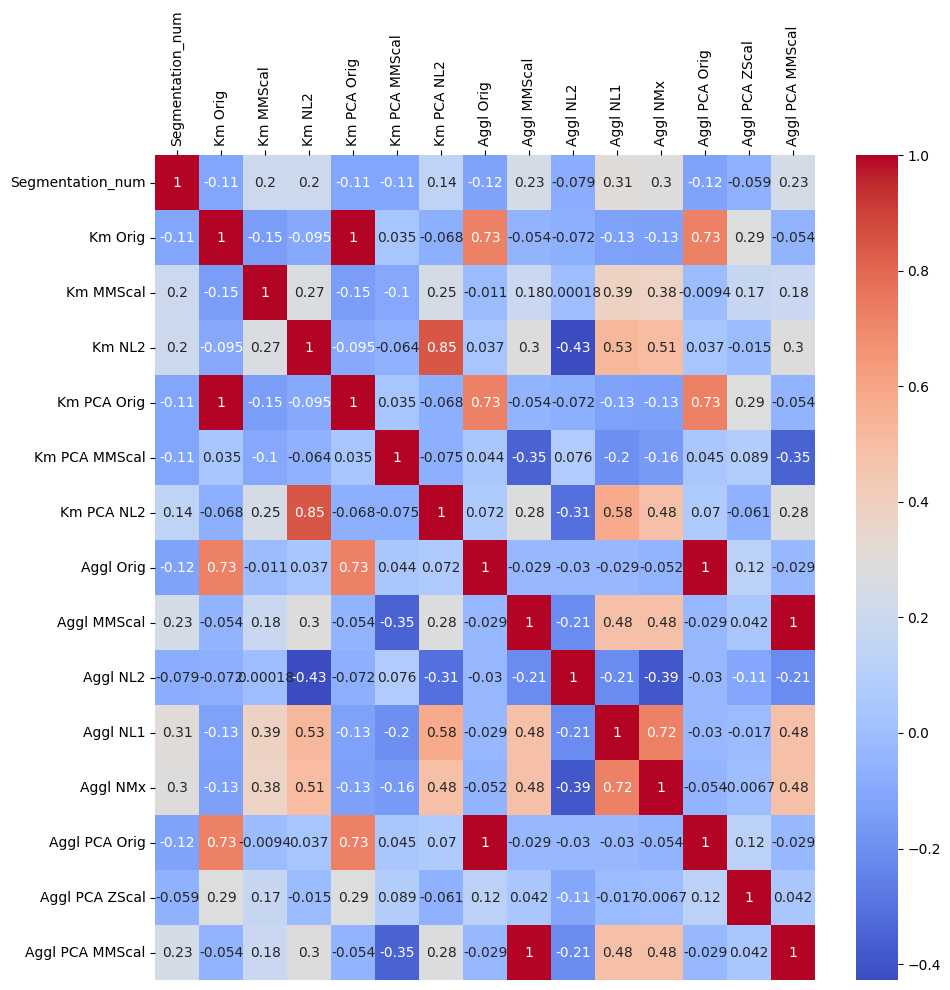

In [1295]:
# correlation matrix of results
plt.figure(figsize=(10,10))
results_corr = results.drop(["Segmentation","ID"], axis = 1)
corr_matrix = results_corr.corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()

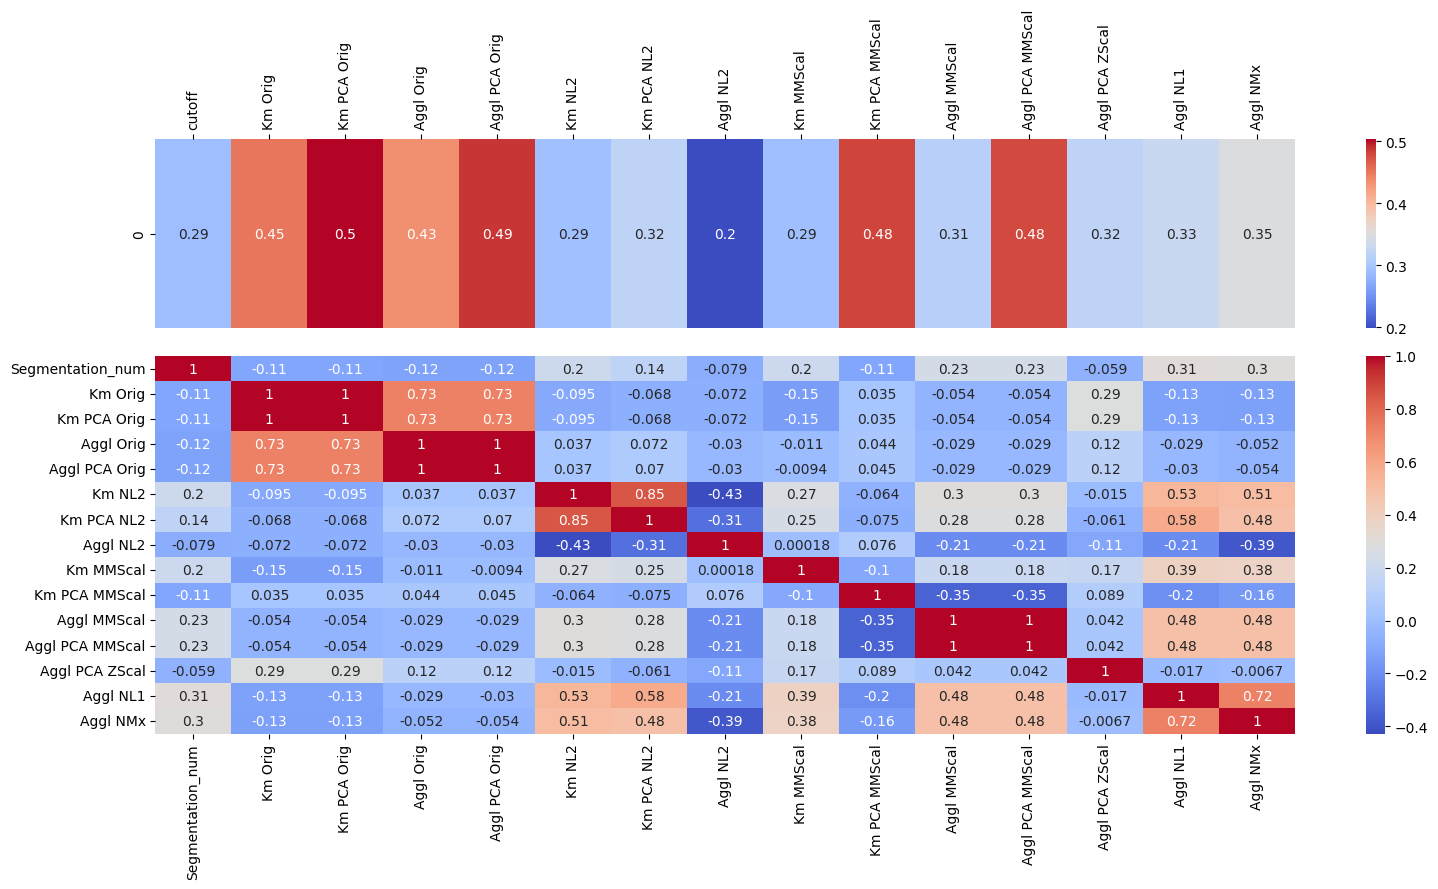

In [1296]:
# correlation matrix of results - better ordered with shilouette scores

fig, axs = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [1, 2]})
shi_matrix = shilscore[["cutoff","Km Orig","Km PCA Orig","Aggl Orig","Aggl PCA Orig","Km NL2","Km PCA NL2","Aggl NL2",
                            "Km MMScal","Km PCA MMScal","Aggl MMScal","Aggl PCA MMScal","Aggl PCA ZScal","Aggl NL1","Aggl NMx"]]
ax = plt.subplot(2,1,1)
ax = sns.heatmap(shi_matrix, annot=True, cmap="coolwarm")
ax.xaxis.tick_top()
plt.xticks(rotation=90)

results_corr = results.drop(["Segmentation","ID"], axis = 1)
corr_matrix = results_corr[["Segmentation_num","Km Orig","Km PCA Orig","Aggl Orig","Aggl PCA Orig","Km NL2","Km PCA NL2","Aggl NL2",
                            "Km MMScal","Km PCA MMScal","Aggl MMScal","Aggl PCA MMScal","Aggl PCA ZScal","Aggl NL1","Aggl NMx"]].corr()
ax2 = plt.subplot(2,1,2)
ax2 = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()




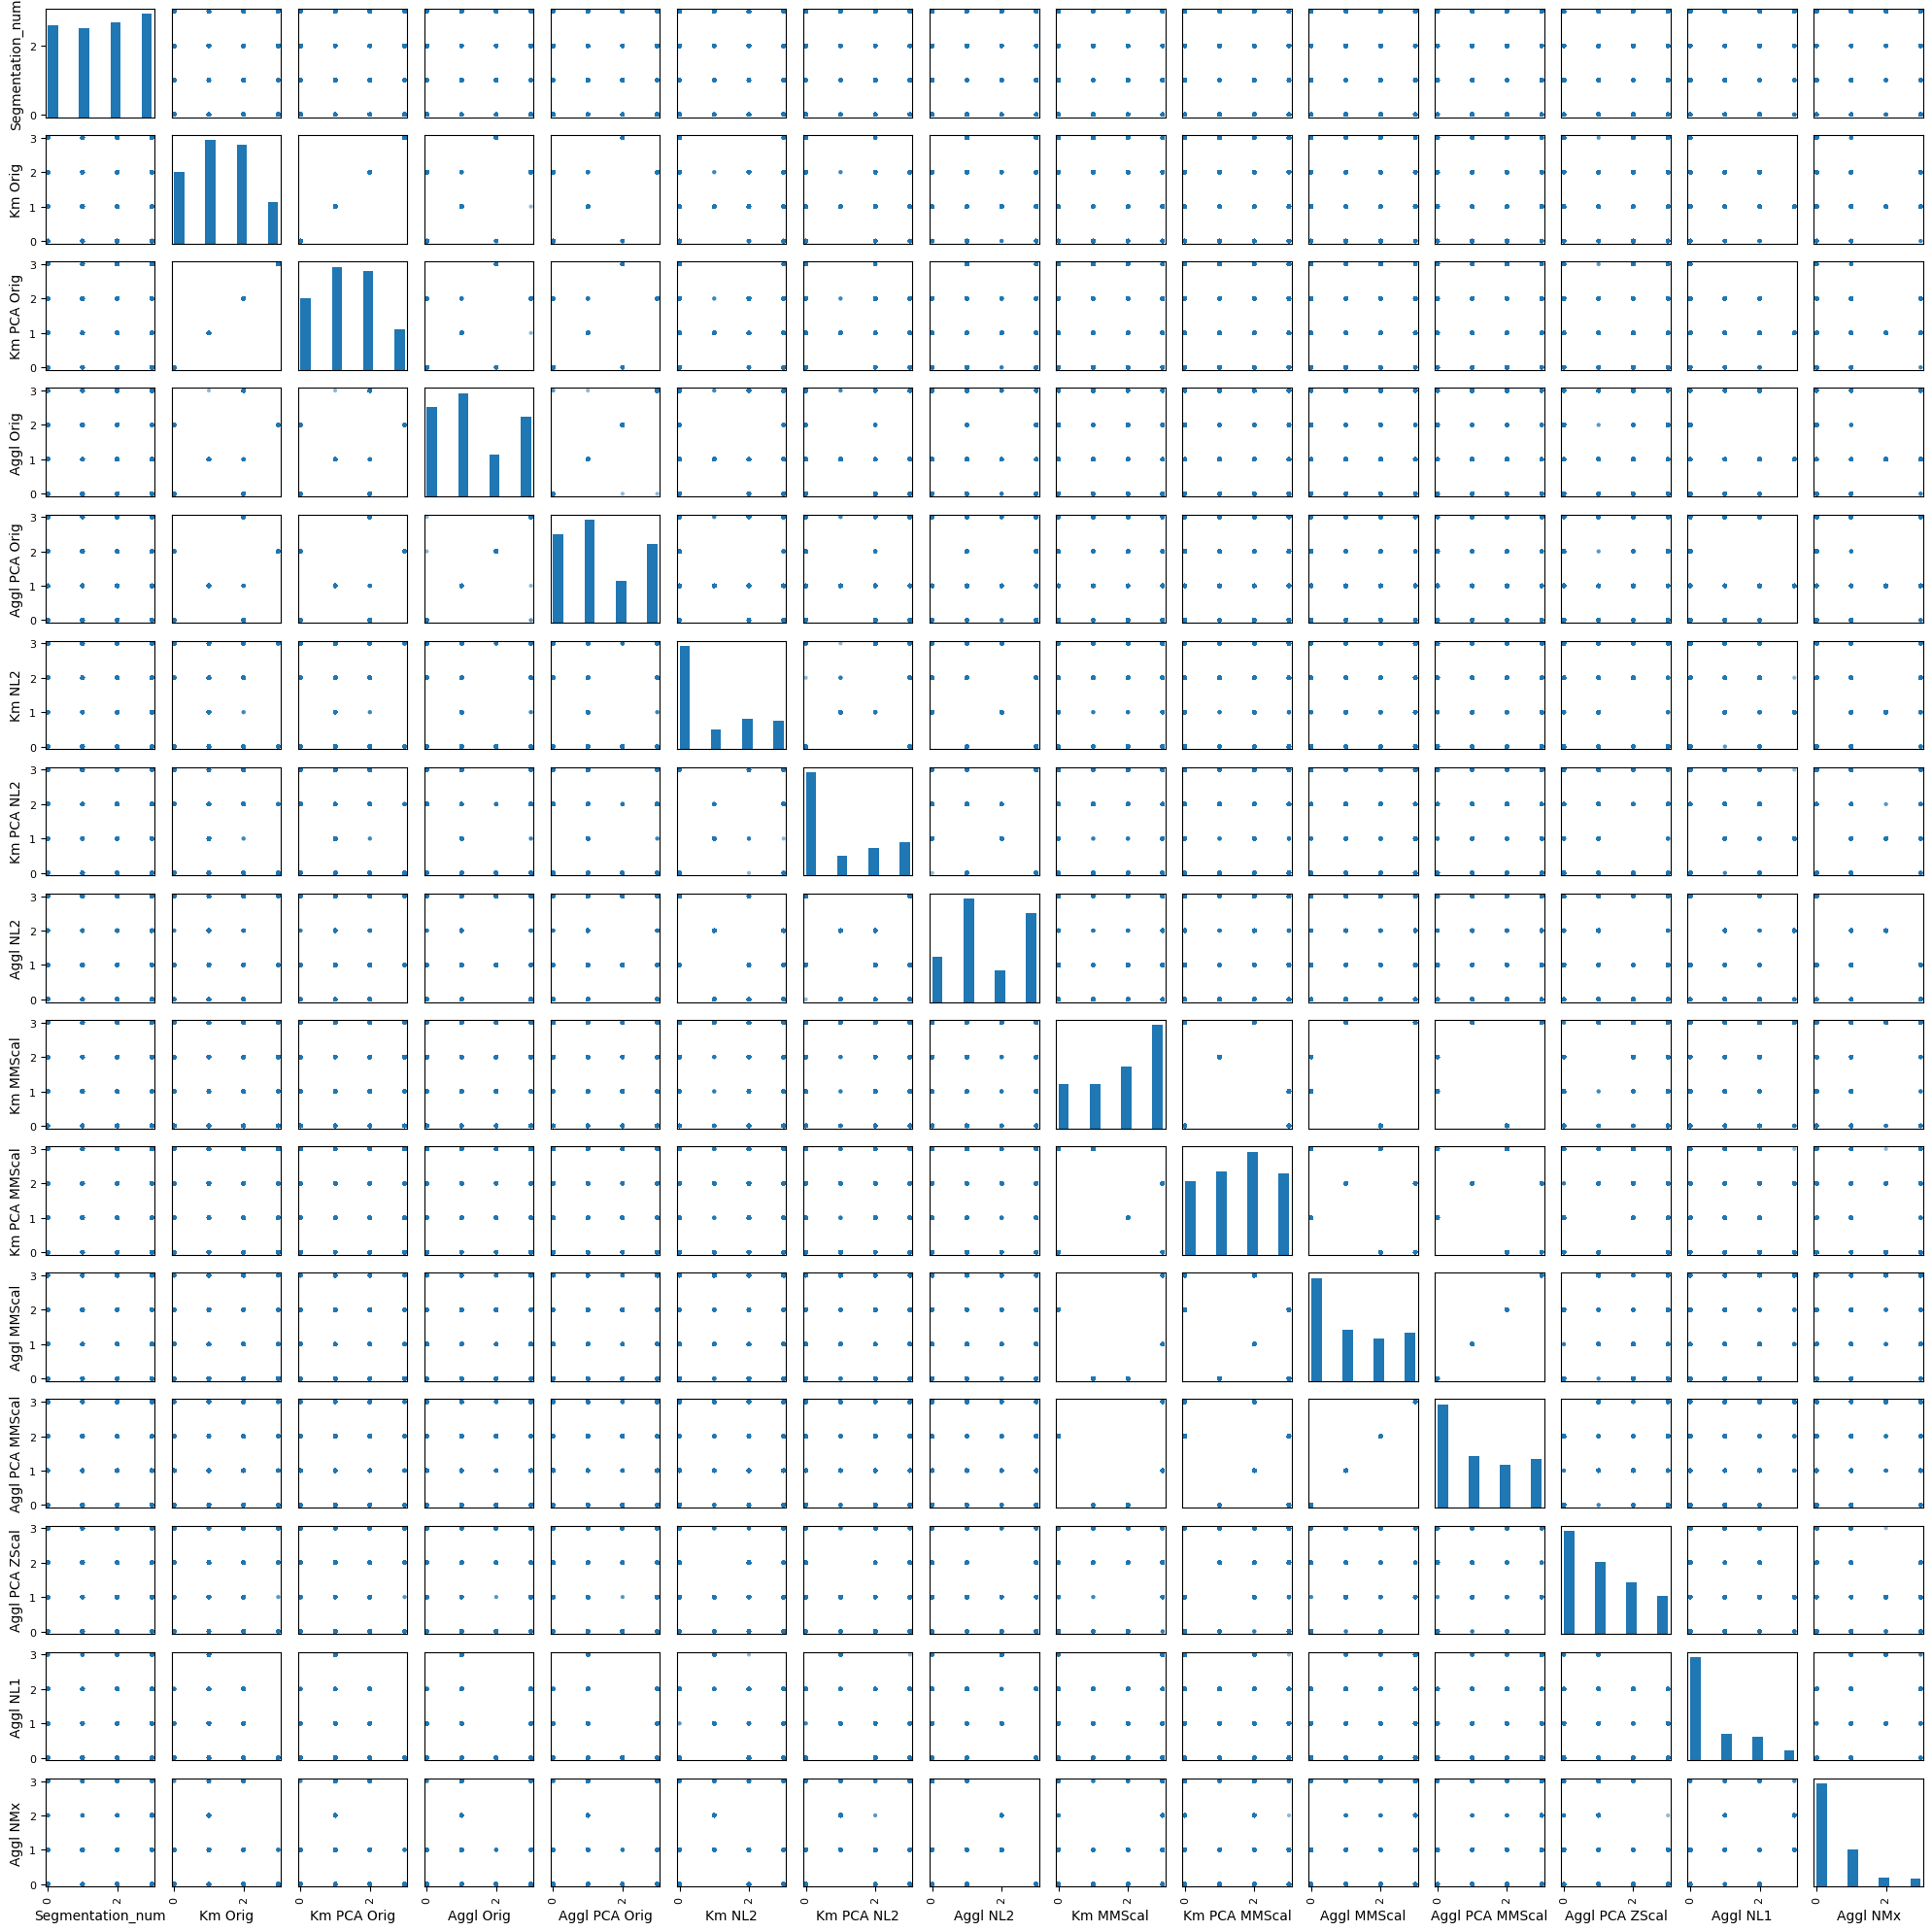

In [1297]:
scat_matrix = results_corr[["Segmentation_num","Km Orig","Km PCA Orig","Aggl Orig","Aggl PCA Orig","Km NL2","Km PCA NL2","Aggl NL2",
                            "Km MMScal","Km PCA MMScal","Aggl MMScal","Aggl PCA MMScal","Aggl PCA ZScal","Aggl NL1","Aggl NMx"]]

# Generate scatter matrix comparable to correlation matrix 
# visualise the data relationships and the correlation numbers if presented beside each other 
scatter_matrix(scat_matrix, figsize=(20,20))

plt.tight_layout()

![alt text](https://github.com/Ddbol/Customer_Segmentation_Unsupervised_ML/blob/main/8feat_model_v_target_results.png?raw=true)

*# Due to the way GitHub handles URL's, if you do not append ?raw=true to the source URL your browser will attempt to load the page which displays the image.

# 4.3.1 Dendrogram Visualisation of subset data


{'icoord': [[5.0, 5.0, 15.0, 15.0], [35.0, 35.0, 45.0, 45.0], [25.0, 25.0, 40.0, 40.0], [95.0, 95.0, 105.0, 105.0], [85.0, 85.0, 100.0, 100.0], [75.0, 75.0, 92.5, 92.5], [65.0, 65.0, 83.75, 83.75], [55.0, 55.0, 74.375, 74.375], [32.5, 32.5, 64.6875, 64.6875], [10.0, 10.0, 48.59375, 48.59375], [125.0, 125.0, 135.0, 135.0], [115.0, 115.0, 130.0, 130.0], [155.0, 155.0, 165.0, 165.0], [145.0, 145.0, 160.0, 160.0], [185.0, 185.0, 195.0, 195.0], [175.0, 175.0, 190.0, 190.0], [152.5, 152.5, 182.5, 182.5], [122.5, 122.5, 167.5, 167.5], [29.296875, 29.296875, 145.0, 145.0]], 'dcoord': [[0.0, np.float64(6.48074069840786), np.float64(6.48074069840786), 0.0], [0.0, np.float64(2.8284271247461903), np.float64(2.8284271247461903), 0.0], [0.0, np.float64(5.537749241945383), np.float64(5.537749241945383), np.float64(2.8284271247461903)], [0.0, np.float64(1.7320508075688772), np.float64(1.7320508075688772), 0.0], [0.0, np.float64(3.0), np.float64(3.0), np.float64(1.7320508075688772)], [0.0, np.float64(3

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num
2191,39,2.0,0,0,3,1,2,3
3050,43,1.0,1,0,0,1,2,2
1600,62,2.0,0,1,0,1,2,5
1632,38,4.0,1,1,1,0,1,5
852,39,7.0,1,1,4,0,1,3
676,28,3.0,0,0,5,0,2,3
2351,73,2.0,0,1,0,1,0,5
5046,62,5.0,1,1,0,1,0,5
3328,48,1.0,0,0,6,1,2,2
1009,43,5.0,1,0,0,1,2,5


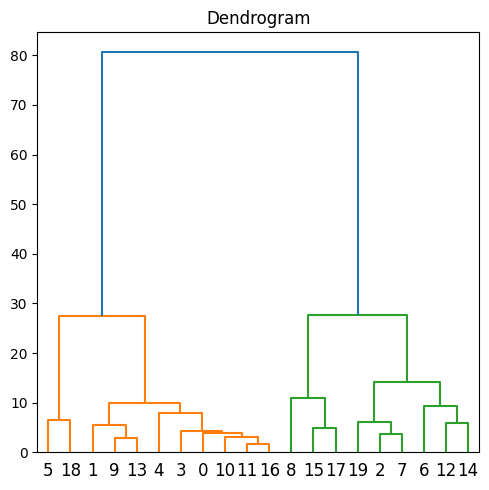

In [ ]:
# dendrogram to find the number of clusters - gives  a suggestion on where to break but you still decide whre to break
#limit variabilty
np.random.seed(42)
# small sample to plot dendogram - usually plot all but complex - original model data unregularised
subset_data = model_data.sample(n=20)

plt.figure(figsize=(5,5))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(subset_data, method = "ward"))
plt.tight_layout()
print(dend)

subset_data

![alt text](https://github.com/Ddbol/Customer_Segmentation_Unsupervised_ML/blob/main/Cluster_visualisation.png?raw=true)

- 3 Feature Data in new workbook: Only ID, gender, age, spending score and segmentation have full data – questions around spending score and profession
Copied notebook, remodelled data for just gender, age and spending score and re-ran 

*# Due to the way GitHub handles URL's, if you do not append ?raw=true to the source URL your browser will attempt to load the page which displays the image.

In [ ]:
# add back in expected and model given grouping to generate table. Taken to Excel and ordered as per dendrogram to give result above.
model_data_copy = model_data
model_data_copy["Segmentation"] = df_cleaned["Segmentation"]
model_data_copy["Segmentation_num"] = results["Segmentation_num"]
model_data_copy["Km Orig"] = results["Km Orig"]
model_data_copy["Aggl Orig"] = results["Aggl Orig"]
#limit variabilty
np.random.seed(42)
# small sample to plot dendogram - usually plot all but complex
subset_data = model_data_copy.sample(n=20)
subset_data

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num,Segmentation,Segmentation_num,Km Orig,Aggl Orig
2191,39,2.0,0,0,3,1,2,3,A,0,2,3
3050,43,1.0,1,0,0,1,2,2,B,1,2,3
1600,62,2.0,0,1,0,1,2,5,C,2,0,0
1632,38,4.0,1,1,1,0,1,5,D,3,2,3
852,39,7.0,1,1,4,0,1,3,D,3,2,3
676,28,3.0,0,0,5,0,2,3,C,2,1,1
2351,73,2.0,0,1,0,1,0,5,C,2,3,2
5046,62,5.0,1,1,0,1,0,5,A,0,0,0
3328,48,1.0,0,0,6,1,2,2,B,1,0,0
1009,43,5.0,1,0,0,1,2,5,C,2,2,3


# 4.3.2 Visualisation of Categories by feature
# 4.3.2.1 New Categries
Age appeared to have strongest correlation. Data index not changed between 2 tables below, can use model from one to look at features in the other. *Note not to add spaces to column names going forward

In [1300]:
model_data_copy

,Age,Family_Size,Gender_num,Ever_Married_num,Profession_num,Graduated_num,SpendSc_num,Var_1_num,Segmentation,Segmentation_num,Km Orig,Aggl Orig
0,22,4.0,1,0,5,0,2,3,D,3,1,1
1,38,3.0,0,1,2,1,0,3,A,0,2,3
2,67,1.0,0,1,2,1,2,5,B,1,3,2
3,67,2.0,1,1,7,1,1,5,B,1,3,2
4,40,6.0,0,1,3,1,1,5,A,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
7472,22,7.0,1,0,9,0,2,0,D,3,1,1
7473,35,4.0,1,0,4,0,2,3,D,3,2,3
7474,33,1.0,0,0,5,1,2,5,D,3,1,1
7475,27,4.0,0,0,5,1,2,5,B,1,1,1


In [1301]:
reduced_data_orig_table

,PCA feat 1,PCA feat 2,KmPCAOrig,AgglPCAOrig
0,-21.564696,2.438398,1,1
1,-5.518983,-0.898428,2,3
2,23.512936,-1.025036,3,2
3,23.534653,3.930564,3,2
4,-3.576957,0.323683,2,3
...,...,...,...,...
7472,-21.660221,6.750821,1,1
7473,-8.580821,1.423009,2,3
7474,-10.459101,2.042581,1,1
7475,-16.532918,2.286490,1,1


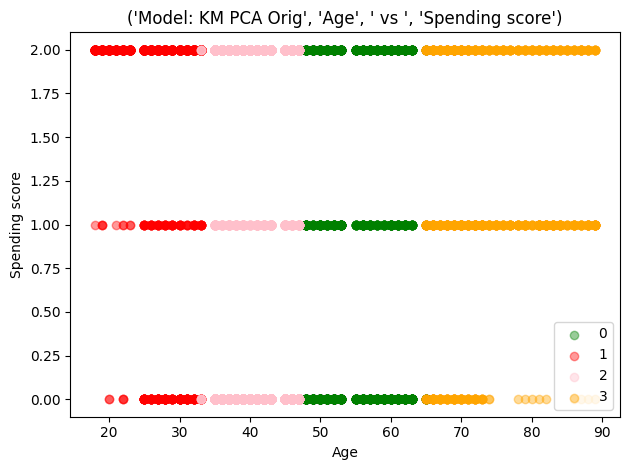

In [1302]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = model_data_copy[reduced_data_orig_table.KmPCAOrig==0]
df2 = model_data_copy[reduced_data_orig_table.KmPCAOrig==1]
df3 = model_data_copy[reduced_data_orig_table.KmPCAOrig==2]
df4 = model_data_copy[reduced_data_orig_table.KmPCAOrig==3]

var_x = "Age"
descrip_x = "Age"
var_y = "SpendSc_num"
descrip_y = "Spending score"
title = ("Model: KM PCA Orig", descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()


Strong correlation of age to the different clusters (1 = approx 20-32, 3 = 65+)
Across the age brackets spending score seems relatively evenly disctributed between categories, except 1 and 3 seem to have less data at the lowest category of spending.

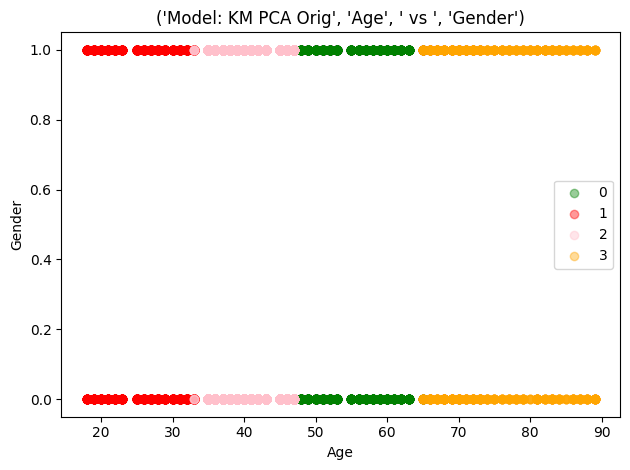

In [1303]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = model_data_copy[reduced_data_orig_table.KmPCAOrig==0]
df2 = model_data_copy[reduced_data_orig_table.KmPCAOrig==1]
df3 = model_data_copy[reduced_data_orig_table.KmPCAOrig==2]
df4 = model_data_copy[reduced_data_orig_table.KmPCAOrig==3]

var_x = "Age"
descrip_x = "Age"
var_y = "Gender_num"
descrip_y = "Gender"
title = ("Model: KM PCA Orig",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

Strong correlation of age to the different clusters (1 = approx 20-32, 3 = 65+)
Across the age brackets gender seems relatively evenly disctributed between categories.

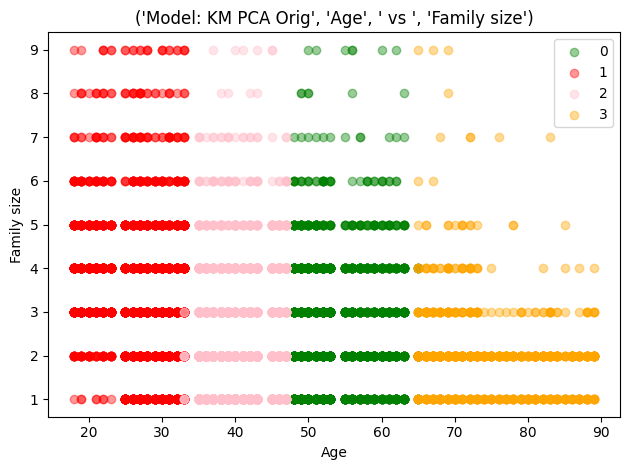

In [1304]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = model_data_copy[reduced_data_orig_table.KmPCAOrig==0]
df2 = model_data_copy[reduced_data_orig_table.KmPCAOrig==1]
df3 = model_data_copy[reduced_data_orig_table.KmPCAOrig==2]
df4 = model_data_copy[reduced_data_orig_table.KmPCAOrig==3]

var_x = "Age"
descrip_x = "Age"
var_y = "Family_Size"
descrip_y = "Family size"
title = ("Model: KM PCA Orig",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

Strong correlation of age to the different clusters (1 = approx 20-32, 3 = 65+)
Across the age brackets family size seems relatively evenly disctributed between categories, from 0-5. Above that there is less people with higher family members. Particularly for the elderly who mostly only have 1-3 family size

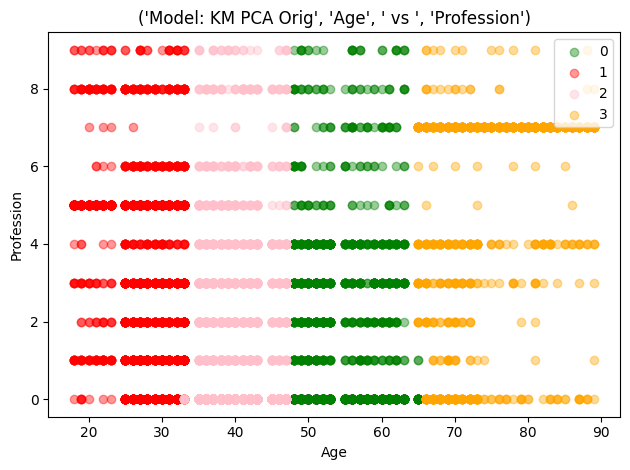

In [1305]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = model_data_copy[reduced_data_orig_table.KmPCAOrig==0]
df2 = model_data_copy[reduced_data_orig_table.KmPCAOrig==1]
df3 = model_data_copy[reduced_data_orig_table.KmPCAOrig==2]
df4 = model_data_copy[reduced_data_orig_table.KmPCAOrig==3]

var_x = "Age"
descrip_x = "Age"
var_y = "Profession_num"
descrip_y = "Profession"
title = ("Model: KM PCA Orig",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

Strong correlation of age to the different clusters (1 = approx 20-32, 3 = 65+)
Across profession the elderly dominant category 7 - Lawyer
Less older people in 5 and 6 Healthcare and Homemaker
- Artist = 0, Doctor = 1, Engineer = 2, Entertainment = 3, Executive = 4,  Healthcare = 5, Homemaker = 6,   Lawyer = 7, Marketing = 8, null= 9 * 

Plotted Histograms of numeric features of each category below and can see the clear age classification and associated data this pulls through. Can see that each category of the original A-D categories (Segmentation_num) are represented in the dataset to varying degrees and hence the low correlation between modeled and targetted segmentation (original A-D). 

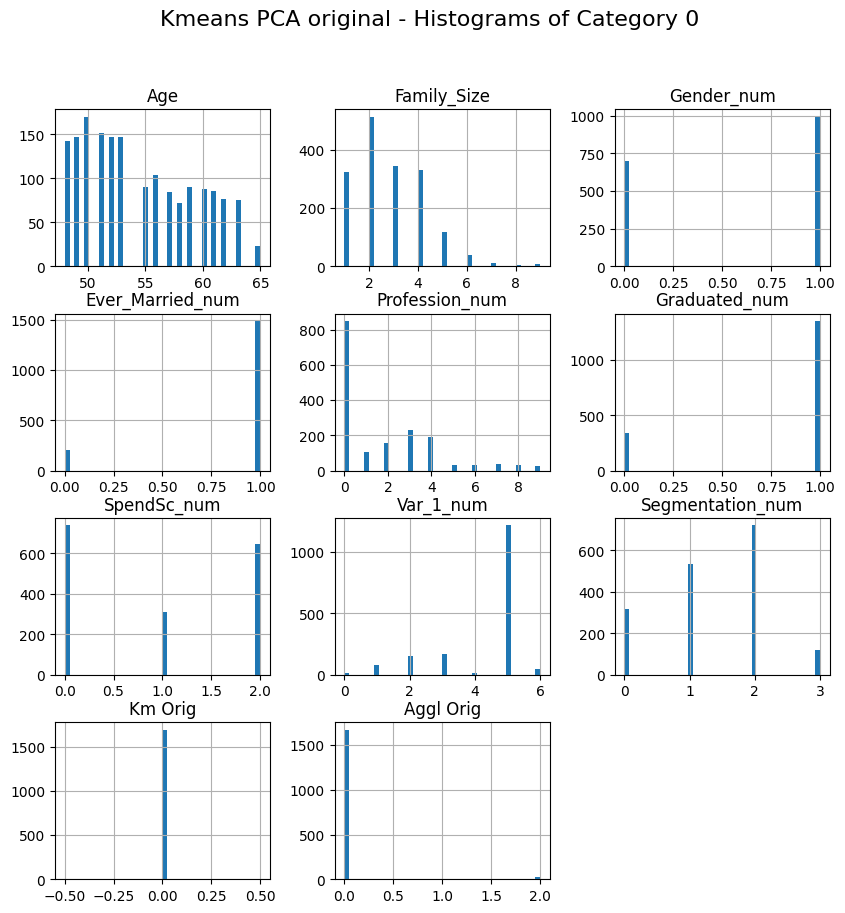

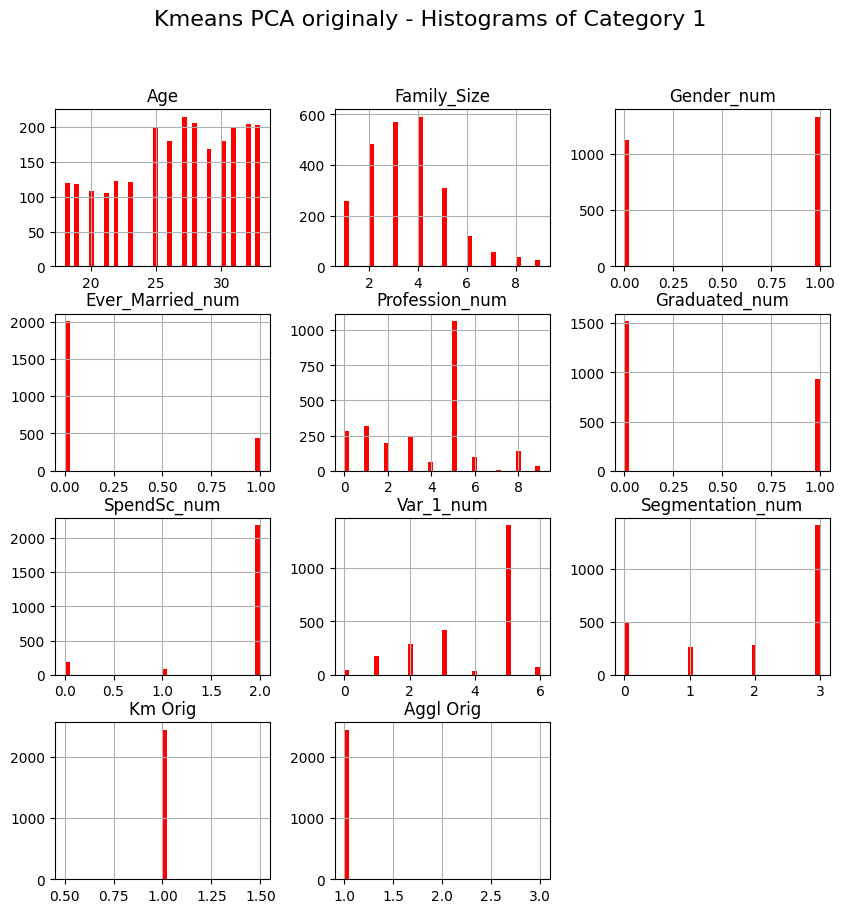

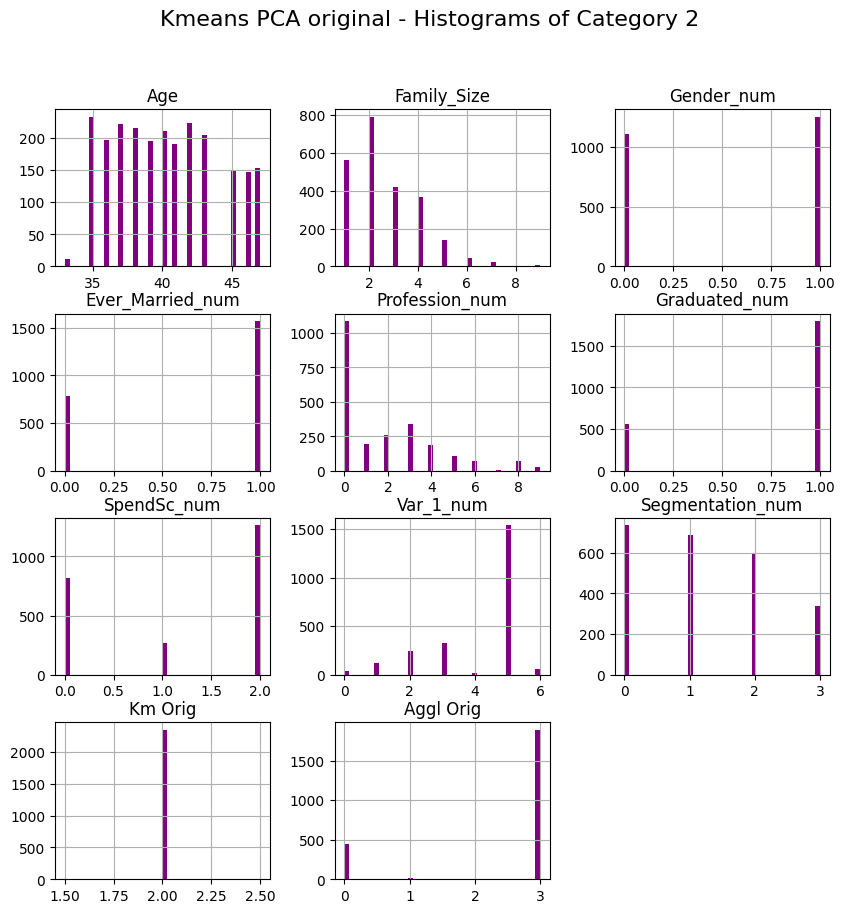

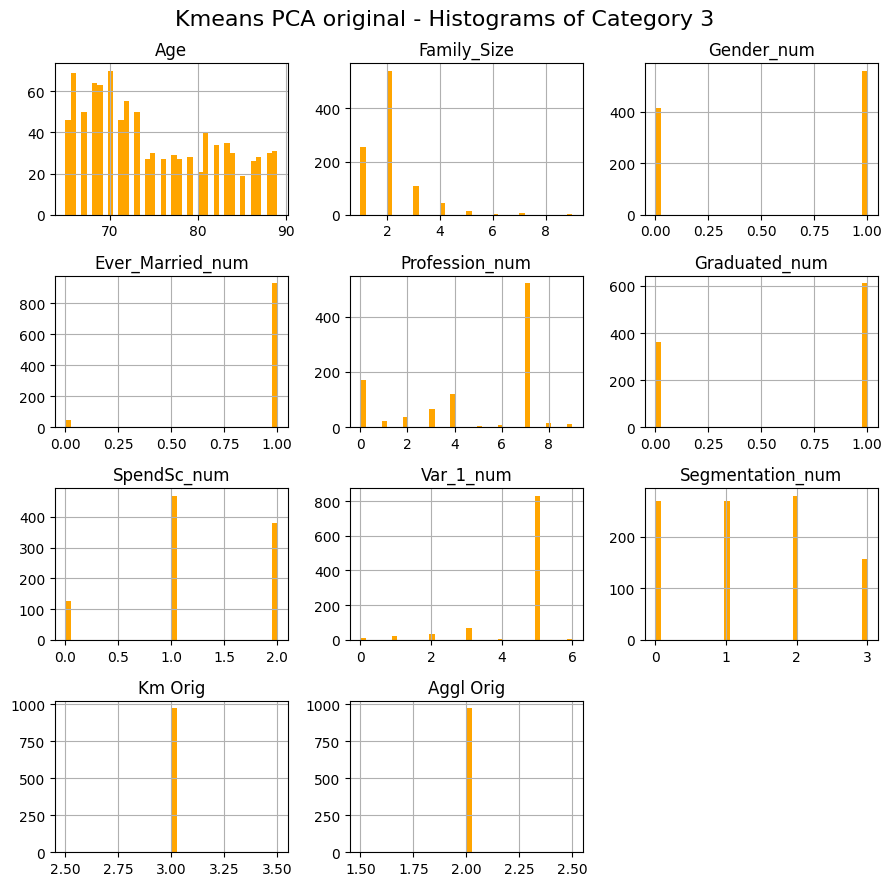

In [1306]:
# Plot histograms of each category for Original A-D category


df1.hist(bins=40, figsize=(10,10))
plt.suptitle('Kmeans PCA original - Histograms of Category 0', fontsize=16)
df2.hist(bins=40,  figsize=(10,10), color = "red")
plt.suptitle('Kmeans PCA originaly - Histograms of Category 1', fontsize=16)
df3.hist(bins=40,  figsize=(10,10), color = "purple")
plt.suptitle('Kmeans PCA original - Histograms of Category 2', fontsize=16)
df4.hist(bins=40,  figsize=(9,9), color = "orange")
plt.suptitle('Kmeans PCA original - Histograms of Category 3', fontsize=16)

plt.tight_layout()


# 4.3.2.2 Old Categories
Compare same graph types for the pre-determined A-D Segmentation Classification. 

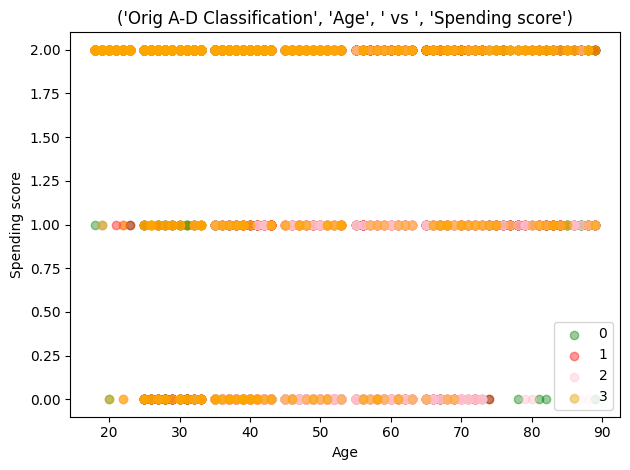

In [1307]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = df_cleaned[df_cleaned.Segmentation_num==0]
df2 = df_cleaned[df_cleaned.Segmentation_num==1]
df3 = df_cleaned[df_cleaned.Segmentation_num==2]
df4 = df_cleaned[df_cleaned.Segmentation_num==3]

var_x = "Age"
descrip_x = "Age"
var_y = "SpendSc_num"
descrip_y = "Spending score"
title = ("Orig A-D Classification",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

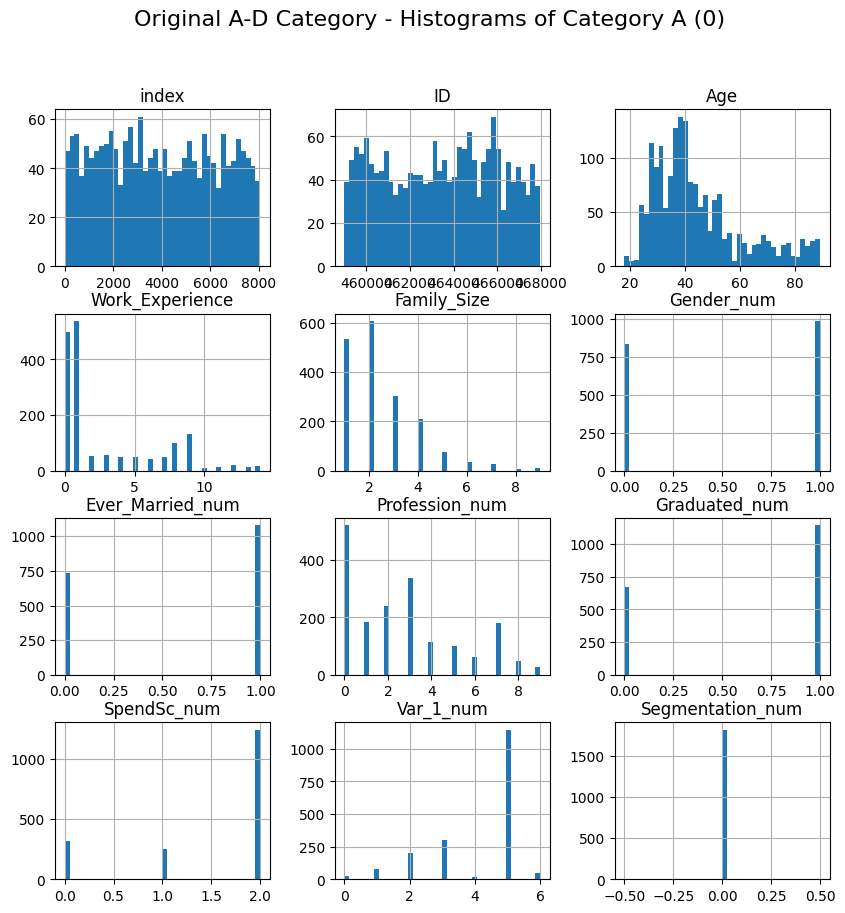

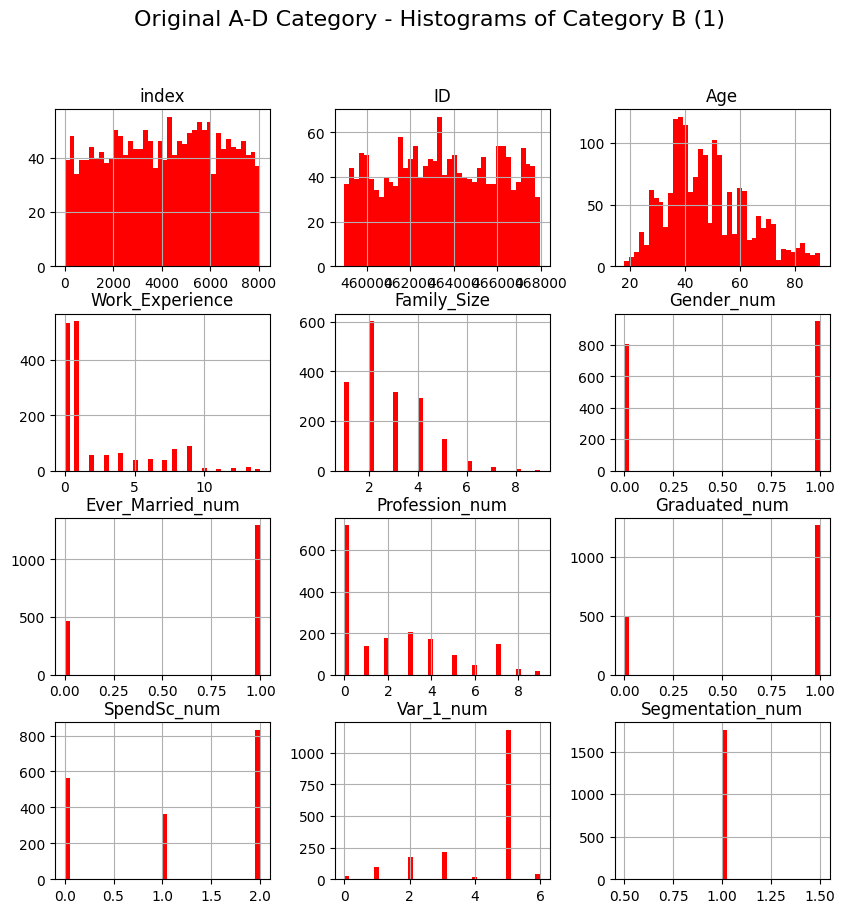

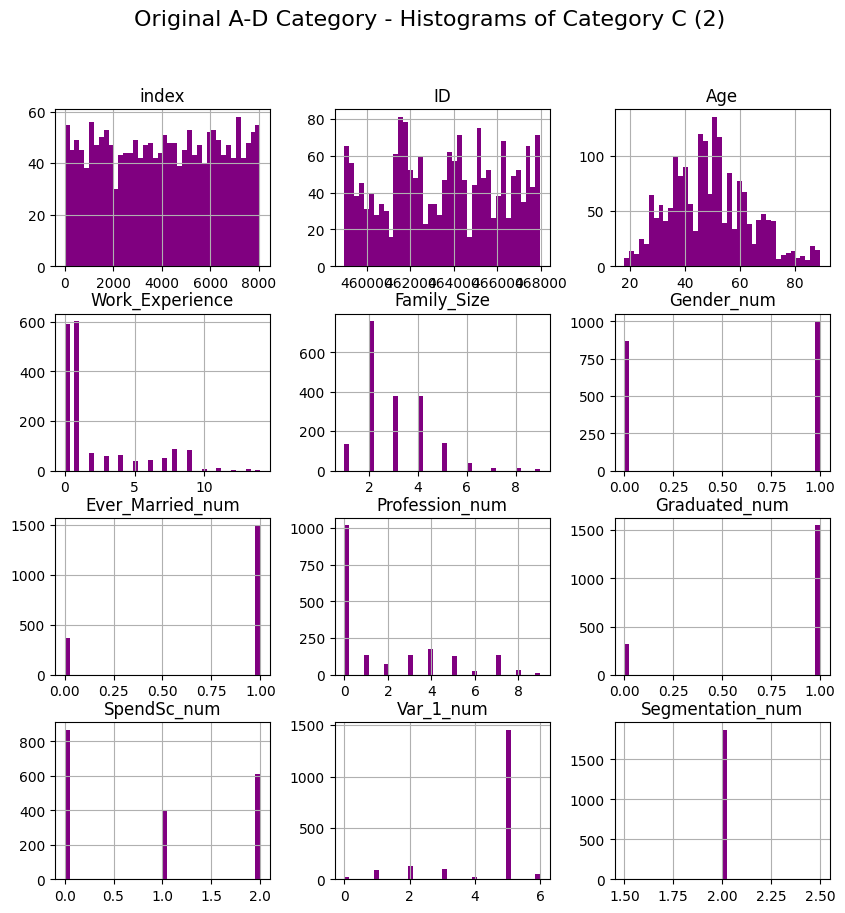

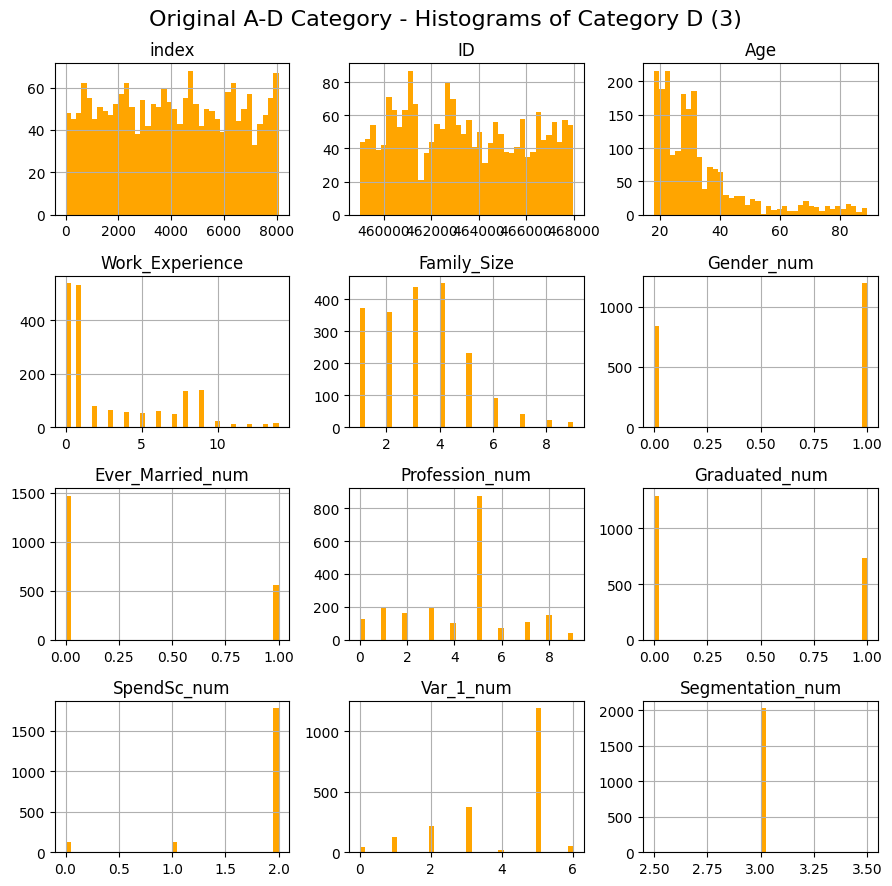

In [1308]:
# Plot histograms of each category for Original A-D category


df1.hist(bins=40, figsize=(10,10))
plt.suptitle('Original A-D Category - Histograms of Category A (0)', fontsize=16)
df2.hist(bins=40,  figsize=(10,10), color = "red")
plt.suptitle('Original A-D Category - Histograms of Category B (1)', fontsize=16)
df3.hist(bins=40,  figsize=(10,10), color = "purple")
plt.suptitle('Original A-D Category - Histograms of Category C (2)', fontsize=16)
df4.hist(bins=40,  figsize=(9,9), color = "orange")
plt.suptitle('Original A-D Category - Histograms of Category D (3)', fontsize=16)

plt.tight_layout()

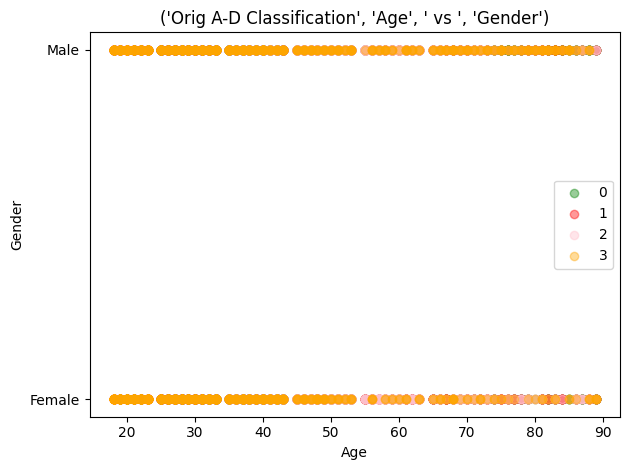

In [1309]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = df_cleaned[df_cleaned.Segmentation_num==0]
df2 = df_cleaned[df_cleaned.Segmentation_num==1]
df3 = df_cleaned[df_cleaned.Segmentation_num==2]
df4 = df_cleaned[df_cleaned.Segmentation_num==3]

var_x = "Age"
descrip_x = "Age"
var_y = "Gender"
descrip_y = "Gender"
title = ("Orig A-D Classification",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

Category 3 leans more towards younger ages but other categories data spread looks very similar making it so unable to model unsupervised. Likely explains why strongest shilouette was typically 2.

No clear correlation age or spending score or any other features investigated (see below). Explaining why the categories couldn't be modelled in the same way by unsupervised learning. 

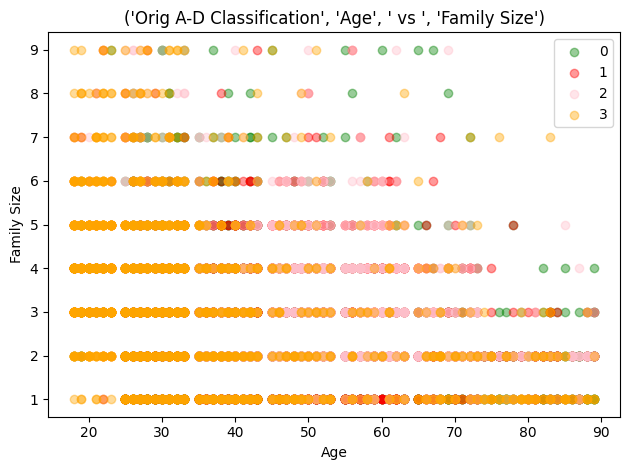

In [1310]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = df_cleaned[df_cleaned.Segmentation_num==0]
df2 = df_cleaned[df_cleaned.Segmentation_num==1]
df3 = df_cleaned[df_cleaned.Segmentation_num==2]
df4 = df_cleaned[df_cleaned.Segmentation_num==3]

var_x = "Age"
descrip_x = "Age"
var_y = "Family_Size"
descrip_y = "Family Size"
title = ("Orig A-D Classification",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()

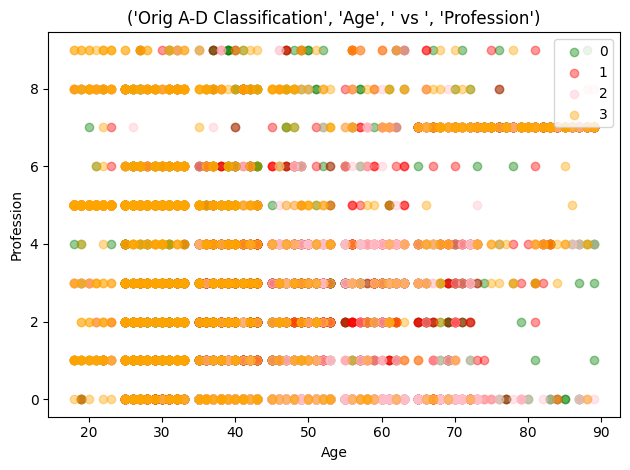

In [1311]:
# Analyse contents of categories
# Scatter plot of clustering

df1 = df_cleaned[df_cleaned.Segmentation_num==0]
df2 = df_cleaned[df_cleaned.Segmentation_num==1]
df3 = df_cleaned[df_cleaned.Segmentation_num==2]
df4 = df_cleaned[df_cleaned.Segmentation_num==3]

var_x = "Age"
descrip_x = "Age"
var_y = "Profession_num"
descrip_y = "Profession"
title = ("Orig A-D Classification",descrip_x," vs ",descrip_y)

plt.scatter(df1[var_x],df1[var_y],color = "green", alpha=0.4, label = 0)
plt.scatter(df2[var_x],df2[var_y],color = "red",alpha=0.4, label = 1)
plt.scatter(df3[var_x],df3[var_y],color = "pink", alpha=0.4,label = 2)
plt.scatter(df4[var_x],df4[var_y],color = "orange", alpha=0.4,label = 3)
plt.xlabel(descrip_x)
plt.ylabel(descrip_y)
plt.legend()
plt.title(title)
plt.tight_layout()



# 5 Conclusion
- Unsupervised learning was not able to reproduce existing A-D customer classification 
    - for both old and newly modelled categories:
        - (a)Visualised the unsupervised model of other features vs age and (b) visualised all numeric data as histograms for each individual category
            - age was the leading seperator in the unsupervised models but not in original A-D classification so can't reproduce
    - More domain knowledge required to replicate the categorisation 
        - oddities in work experience and spending score noted in data exploration
- Future work/improvements
    - Could have split dataset into training and test data with known answer
    - Iterative approach taken – function or pipeline would reduce coding lines for review
